# TODO

- [ ] Checar importância da significância estatística dos coeficientes da regressão
- [ ] Testar começo da série em 1987, 1990, 1991

# Setup

In [1]:
!rm *.csv # Removendo dados anteriores
!rm -R figs # Removendo pasta de figuras
!rm -R tabs # Removendo pasta de tabelas
!mkdir figs # Criando pasta para salvar figuras
!mkdir tabs # Criando pasta para salvar tabelas
!ls

Benchmark.html	 Clean-checkpoint.ipynb  tabs
Benchmark.ipynb  Clean.ipynb		 Teste.ipynb
Benchmark.pdf	 figs			 VECM_Infla.ipynb
Benchmark.Rmd	 SeriesTemporais.Rproj	 VECM_TxPropria.ipynb


# Introdução

Esta rotina ajusta um modelo de séries temporais. 
Será testado se o investimento residencial ($I_h$) depende da <u>taxa própria de juros</u> dos imóveis, ou seja,

$$
I_h = f(r_{mo}, p_h)
$$
em que

- $I_h$ Investimento residencial

  + **Série:** PRFI
  + Com ajuste sazonal
  + Trimestral
  
- $r_{mo}$ taxa de juros das hipotecas
  + **Série:** MORTGAGE30US
  - Sem ajuste sazonal
  - Semanal (encerrado às quintas feiras)

- $p_h$ Inflação de imóveis: Índice Case-Shiller

  + **Série:** CSUSHPISA
  + Com ajuste sazonal, Jan 2000 = 100
  + Mensal
  
**Nota:** Uma vez que pretende-se utilizar os resultados obtidos deste modelo em um trabalho futuro, os resultados serão checados tanto em python quanto em gretl, ambos softwares livres.

# Carregando pacotes

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

# Pacotes gerais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
# Pacotes estatísticos

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, CointRankResults, VECM, select_coint_rank

from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS, KPSS, ADF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pacotes para importação de dados

import pandas_datareader.data as web
from scipy.stats import yeojohnson

# Configurações do notebook

plt.style.use('seaborn-white')
#start = datetime.datetime(1987, 1, 1)
start = datetime.datetime(1992, 1, 1)
end = datetime.datetime(2019, 7, 1)

# Importando dados

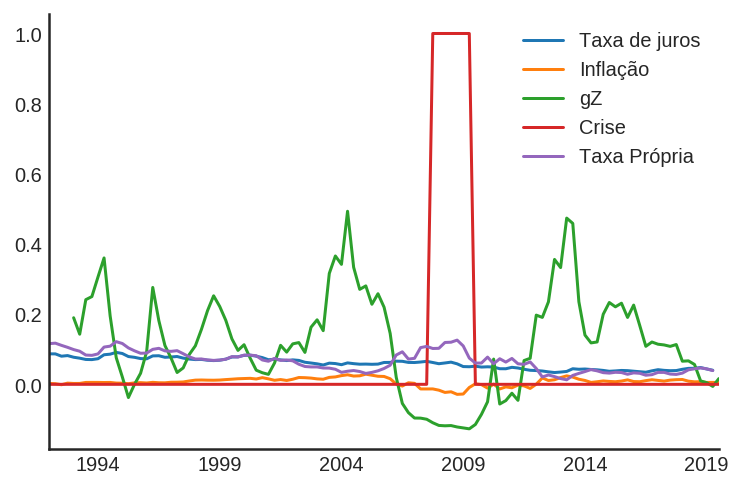

,Taxa de juros,Inflação,gZ,Crise,Taxa Própria,d_Taxa Própria,d_gZ,d_Inflação,d_Taxa de juros
,,,,,,,,,
2018-06-30,0.045446,0.009007,0.066893,0,0.041386,0.009454,0.001012,-0.004757,0.002623
2018-09-30,0.045669,0.007121,0.056555,0,0.044225,0.002839,-0.010338,-0.001885,0.000223
2018-12-31,0.047846,0.007440,0.009721,0,0.046668,0.002443,-0.046833,0.000318,0.002177
2019-03-31,0.043738,0.005347,0.004754,0,0.044109,-0.002559,-0.004968,-0.002093,-0.004108
2019-06-30,0.040108,0.005519,-0.006007,0,0.039164,-0.004945,-0.010761,0.000172,-0.003631


In [3]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
]
df.index.name = ""

df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df['Preço dos imóveis'] = df['Preço dos imóveis']/df['Preço dos imóveis'][0]
df["Inflação"] = df["Preço dos imóveis"].pct_change(12)
df = df.resample('Q').mean()

df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1
df['Taxa Própria'], *_ = yeojohnson(df['Taxa Própria'])

df['gZ'], *_ = yeojohnson(df["Investimento residencial"].pct_change(4))

df["Crise"] = [0 for i in range(len(df["gZ"]))]
for i in range(len(df["Crise"])):
    if df.index[i] > datetime.datetime(2007,12,1) and df.index[i] < datetime.datetime(2009,7,1):
        df["Crise"][i] = 1

df.to_csv("Dados_yeojohnson.csv")


df.to_csv(
    "Dados_yeojohnson_ascii.csv", 
    encoding='ascii', 
    header = [
        #'data',
        'invRes',
        'preco',
        'juros',
        'infla',
        'taxap',
        'gz',
        'crise',
          ], 
         )

df = df[["Taxa de juros", "Inflação", "gZ", "Crise", "Taxa Própria"]]
df.plot()
sns.despine()
plt.show()

df["d_Taxa Própria"] = df["Taxa Própria"].diff()
df["d_gZ"] = df["gZ"].diff()
df["d_Inflação"] = df["Inflação"].diff()
df["d_Taxa de juros"] = df['Taxa de juros'].diff()
df = df.dropna()
df.tail()

In [4]:
# Teste de raíz unitária

def testes_raiz(df=df["gZ"], original_trend='c', diff_trend='c'):
    """
    serie: Nome da coluna do df
    orignal_trend: 'c', 'ct', 'ctt'
    diff_trend: 'c', 'ct', 'ctt'
    
    Plota série o original e em diferenta e retorna testes de raíz unitária
    """
    fig, ax = plt.subplots(1,2)

    df.plot(ax=ax[0], title='série original')
    df.diff().plot(ax=ax[1], title='série em diferença')

    plt.tight_layout()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots(2,2)
    
    plot_acf(df, ax=ax[0,0], title='ACF: serie original') 
    plot_pacf(df, ax=ax[0,1], title='PACF: serie original')
    
    plot_acf(df.diff().dropna(), ax=ax[1,0], title='ACF: serie em diferença') 
    plot_pacf(df.diff().dropna(), ax=ax[1,1], title='PACF: serie em diferença')
    
    plt.tight_layout()
    sns.despine() 
    plt.show()

    
    # Zivot Andrews
    print('\nZIVOT ANDREWS')
    print(ZivotAndrews(df, trend = original_trend).summary(),"\n")
    print(ZivotAndrews(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nADF')
    print(ADF(df, trend=original_trend).summary(),"\n")
    print(ADF(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nDFGLS')
    print(DFGLS(df, trend=original_trend).summary(),"\n")
    print(DFGLS(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nKPSS')
    print(KPSS(df, trend = original_trend).summary(),"\n")
    print(KPSS(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nPhillips Perron')
    print(PhillipsPerron(df, trend=original_trend).summary(),"\n")
    print(PhillipsPerron(df.diff().dropna(), trend=diff_trend).summary(),"\n")

In [5]:
# Teste de cointegração

def cointegracao(ts0, ts1, signif = 0.05, lag=1):
  trends = ['nc', 'c', 'ct', 'ctt']
  for trend in trends:
    print(f"\nTestando para lag = {lag} e trend = {trend}")
    result = coint(ts0, ts1, trend = trend, maxlag=lag)
    print('Null Hypothesis: there is NO cointegration')
    print('Alternative Hypothesis: there IS cointegration')
    print('t Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < signif:
      print('CONCLUSION: REJECT null Hypothesis: there IS cointegration\n')
    else:
      print('CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration\n')
    
def testes_coint(series, maxlag=8):
    for i in range(1, maxlag):
        print(50*'=')
        cointegracao(
            ts0=series.iloc[:, 0],
            ts1=series.iloc[:, 1:],
            signif=0.05,
            lag=i
        )
        print("\nTESTE DE JOHANSEN\n")
        rank_sel = select_coint_rank(endog=series, k_ar_diff=i, det_order=1).rank
        print(f'Para lag = {i}, Rank = {rank_sel}')
        print(10*'=')

In [6]:
### Resíduos

def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1] < signif
    for j in range(k):
      print("Reject H0 on lag " ,j+1,"? ", result[j])
    print("\n")
    
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

def analise_residuos(results, nmax=15):
    
    residuals = pd.DataFrame(results.resid, columns = results.names)
    
    residuals.plot()
    sns.despine()
    plt.show()
    
    for serie in residuals.columns:
    
        fig, ax = plt.subplots(1,2)

        plot_acf(residuals[serie], ax=ax[0], title=f'ACF Resíduo de {serie}', zero=False) 
        plot_pacf(residuals[serie], ax=ax[1], title=f'PACF Resíduo de {serie}', zero=False)
        
        plt.tight_layout()
        sns.despine() 
        plt.show()

    print('AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU\n')
    print(results.test_whiteness(nlags=nmax).summary())
    print('\nAUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO\n')
    print(results.test_whiteness(nlags=nmax, adjusted=True).summary())
    print('\nLJUNGBOX\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=False)
    print('\nBOXPIERCE\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=True)
    print('\nNORMALIDADE\n')
    print(results.test_normality().summary())
    print('\nHOMOCEDASTICIDADE\n')
    ARCH_LM(residuals)
    
    return residuals
    

In [7]:
results = []
def plot_lags(results = results, trimestres=[2, 5]):
    series = results.names
    fig, ax = plt.subplots(len(trimestres),2, figsize = (16,10))
    
    for i in range(len(trimestres)):
        sns.regplot(y = df[series[0]], x = df[series[1]].shift(-trimestres[i]), color = 'black', ax = ax[i,0], order = 2)
        ax[i,0].set_xlabel(f'{series[1]} defasada em {trimestres[i]} trimestres')

        sns.regplot(x = df[series[0]].shift(-trimestres[i]), y = df[series[1]], color = 'black', ax = ax[i,1], order = 2)
        ax[i,1].set_xlabel(f'{series[0]} defasada em {trimestres[i]} trimestres')

## Investimento residencial ($g_Z$)

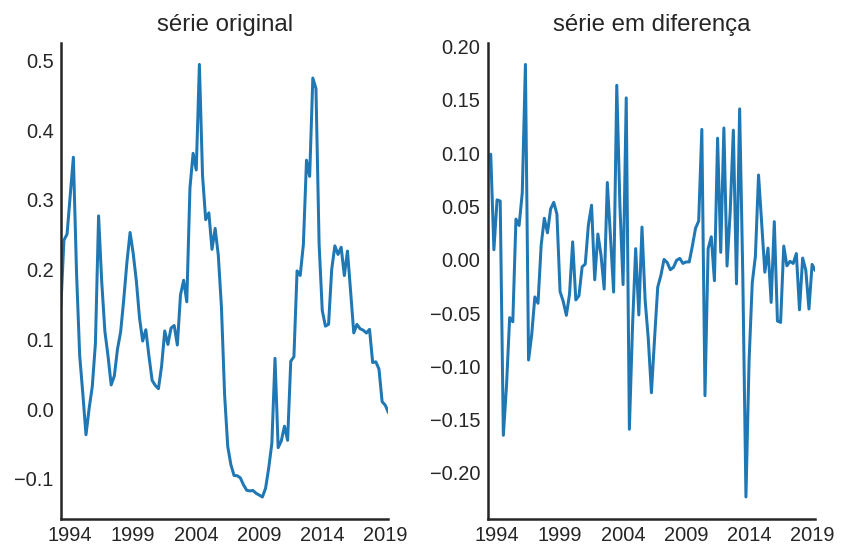

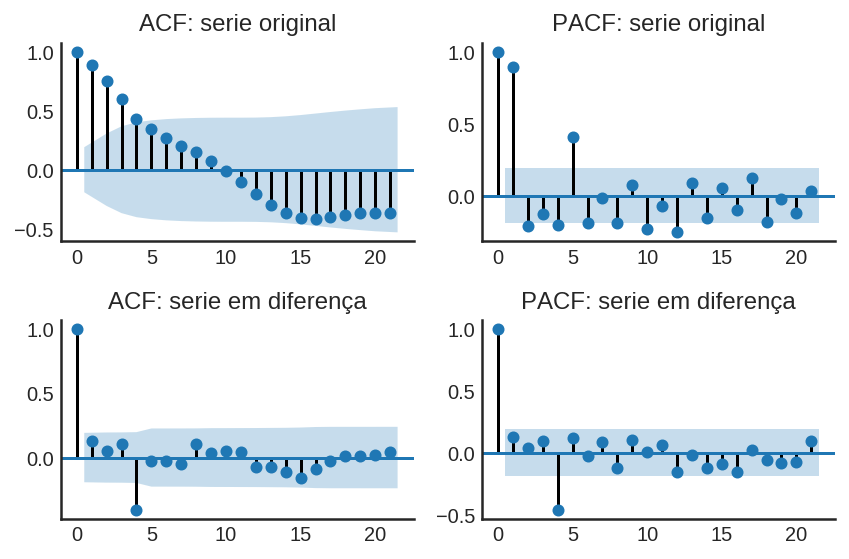


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -3.670
P-value                         0.568
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -7.628
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.849
P-value                         0.052
Lags                                9
------

In [8]:
testes_raiz(df=df['gZ'])

**Conclusão:** Série  não é fracamente estacionária.

## Taxa própria

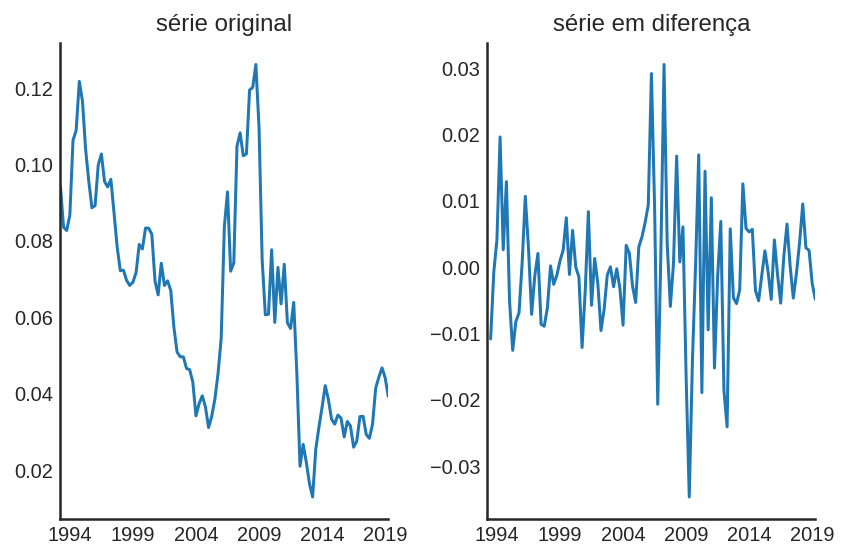

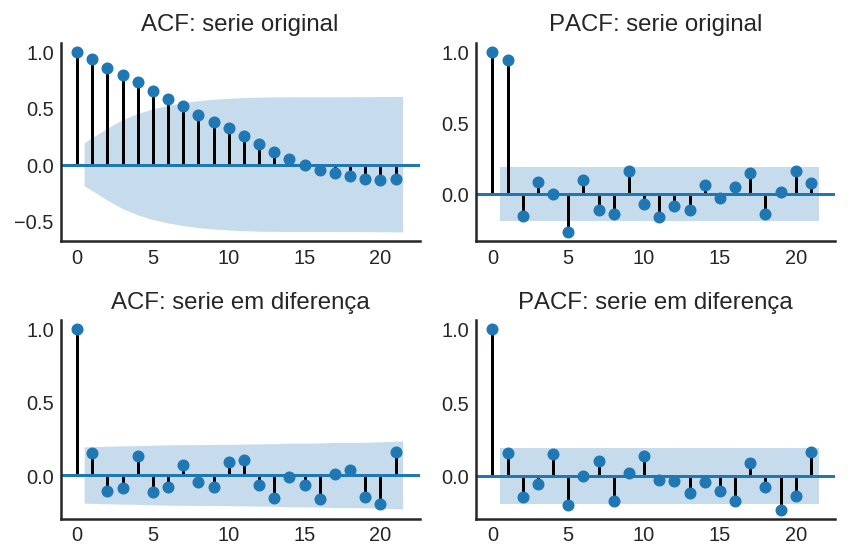


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -4.382
P-value                         0.159
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -6.340
P-value                         0.000
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.268
P-value                         0.182
Lags                                4
------

In [9]:
testes_raiz(df['Taxa Própria'])

**Conclusão:** Será tomada em primeira diferença.

## Inflação

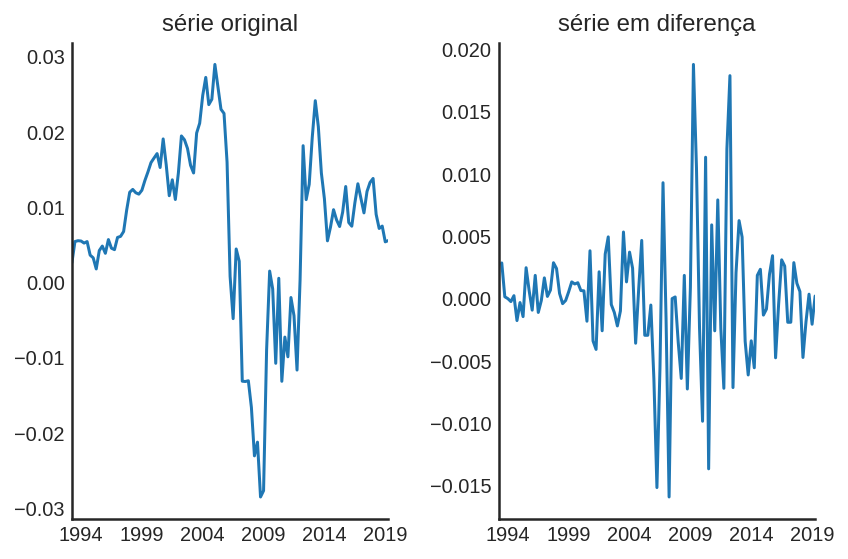

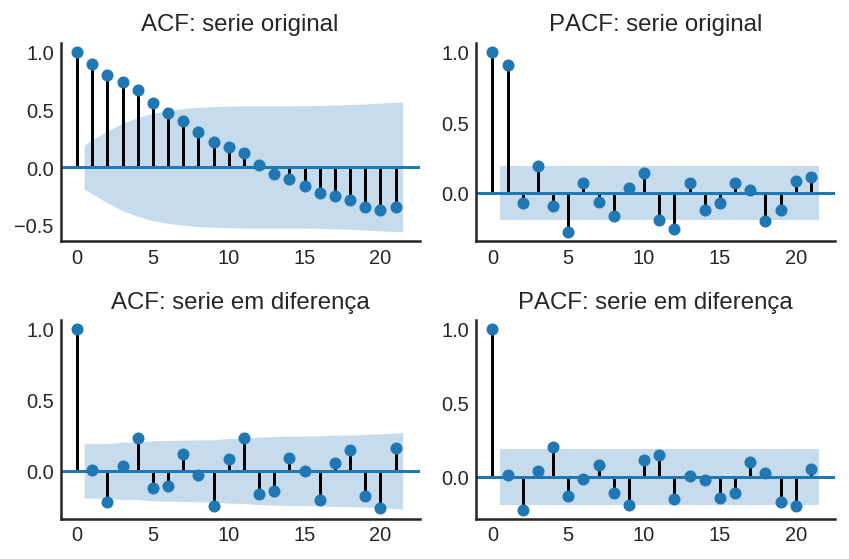


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -4.958
P-value                         0.033
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -9.841
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.534
P-value                         0.107
Lags                                4
------

In [10]:
testes_raiz(df['Inflação'])

## Taxa de juros das hipotecas

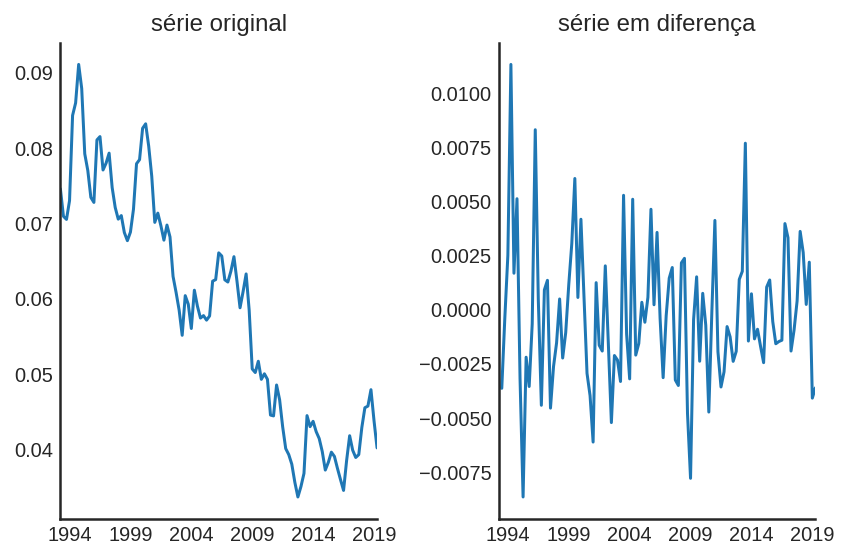

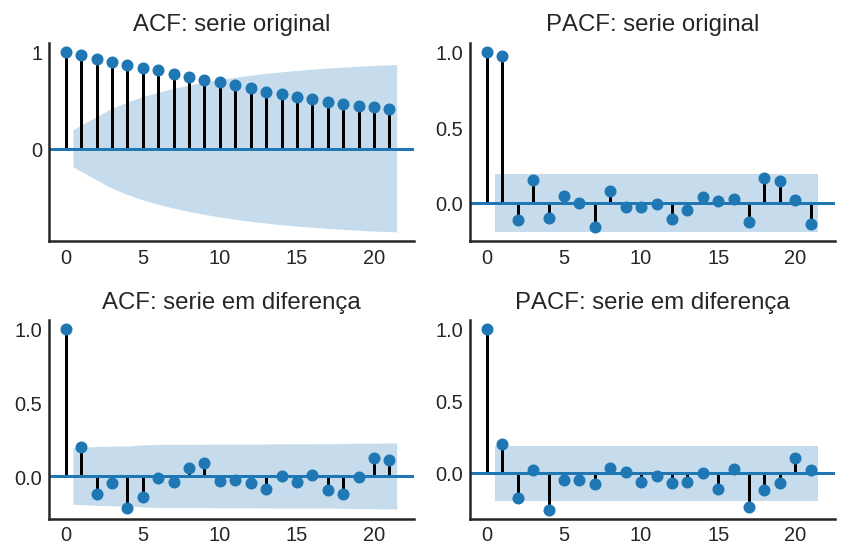


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -5.298
P-value                         0.025
Lags                                3
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -7.625
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.892
P-value                         0.012
Lags                  

In [11]:
testes_raiz(df['Taxa de juros'], original_trend='ct')

# Cointegração

In [12]:
testes_coint(series=df[['gZ', 'Taxa Própria']], maxlag=9)


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.616725
p-value: 0.070613
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.755865
p-value: 0.180132
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.268558
p-value: 0.000283
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.389378
p-value: 0.000746
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Para lag = 1, Rank = 2

Testando para lag = 2 e tr

In [13]:
testes_coint(series=df[['gZ', 'Inflação', 'Taxa de juros']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.307978
p-value: 0.002198
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.476549
p-value: 0.005442
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.636831
p-value: 0.000229
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.827974
p-value: 0.000397
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Para lag = 1, Rank = 3

Testando para lag = 2 e trend = nc
Null Hypothes

In [14]:
testes_coint(series=df[['gZ', 'Inflação']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.294970
p-value: 0.000353
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.385287
p-value: 0.001878
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.376467
p-value: 0.008531
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.315458
p-value: 0.032046
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Para lag = 1, Rank = 2

Testando para lag = 2 e trend = nc
Null Hypothes

# VECM

In [15]:
from statsmodels.tsa.vector_ar.vecm import select_order

det = 'cili'
order_vec = select_order(
    df[[
        #"Inflação", 
        "Taxa Própria", 
        "gZ"
    ]], 
    #exog=df[["Taxa de juros"]],
    maxlags=15, deterministic=det)

with open('./tabs/VECM_lag_order.tex','w') as fh:
    fh.write(order_vec.summary().as_latex_tabular(tile = "Selação ordem do VECM"))

order_vec.summary()

,AIC,BIC,FPE,HQIC
0,-15.03,-14.75*,2.968e-07,-14.92*
1,-15.04,-14.65,2.937e-07,-14.88
2,-15.01,-14.50,3.046e-07,-14.80
3,-15.03,-14.42,2.968e-07,-14.78
4,-15.13,-14.40,2.693e-07,-14.84
5,-15.13,-14.29,2.707e-07,-14.79
6,-15.17*,-14.22,2.596e-07*,-14.79
7,-15.14,-14.08,2.693e-07,-14.71
8,-15.12,-13.94,2.773e-07,-14.64
9,-15.04,-13.76,3.006e-07,-14.52


Det. terms outside the coint. relation & lagged endog. parameters for equation Taxa Própria
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.Taxa Própria     0.3200      0.128      2.495      0.013       0.069       0.571
L1.gZ              -0.0014      0.021     -0.066      0.948      -0.043       0.040
L2.Taxa Própria     0.0002      0.127      0.002      0.999      -0.249       0.249
L2.gZ               0.0125      0.021      0.599      0.549      -0.028       0.053
L3.Taxa Própria    -0.0966      0.127     -0.760      0.447      -0.346       0.153
L3.gZ               0.0013      0.020      0.065      0.948      -0.037       0.040
L4.Taxa Própria     0.2909      0.118      2.466      0.014       0.060       0.522
L4.gZ               0.0130      0.019      0.703      0.482      -0.023       0.049
L5.Taxa Própria    -0.1931      0.117     -1.650      0.099      -0.

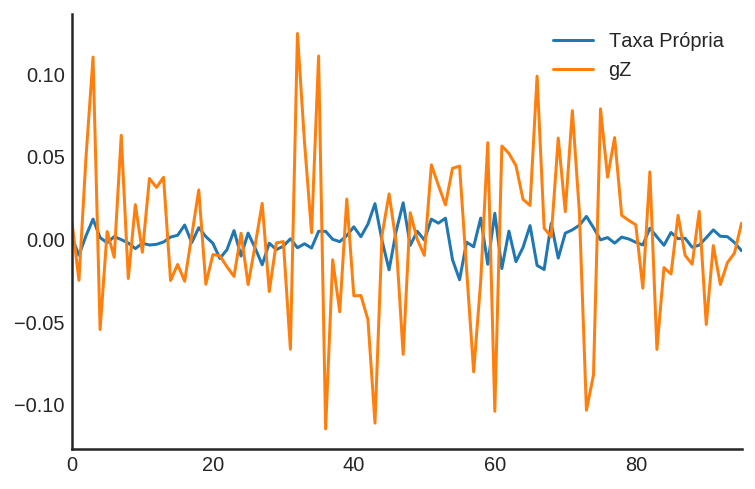

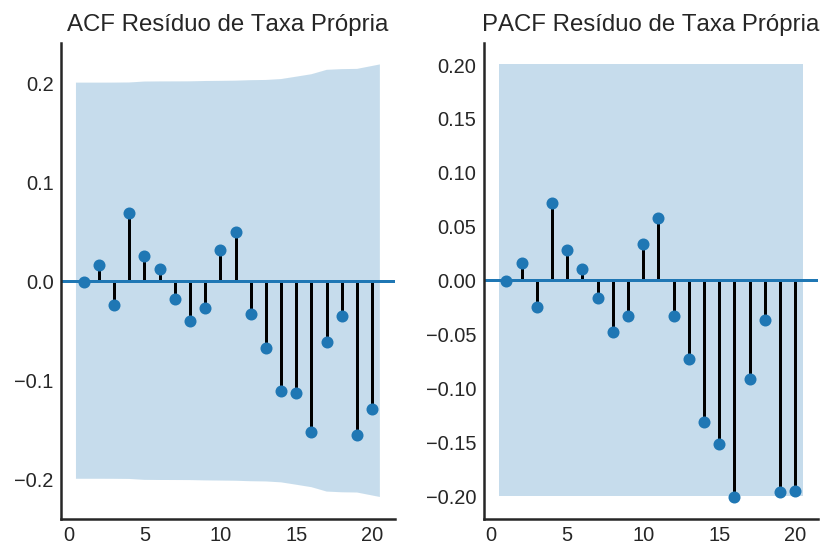

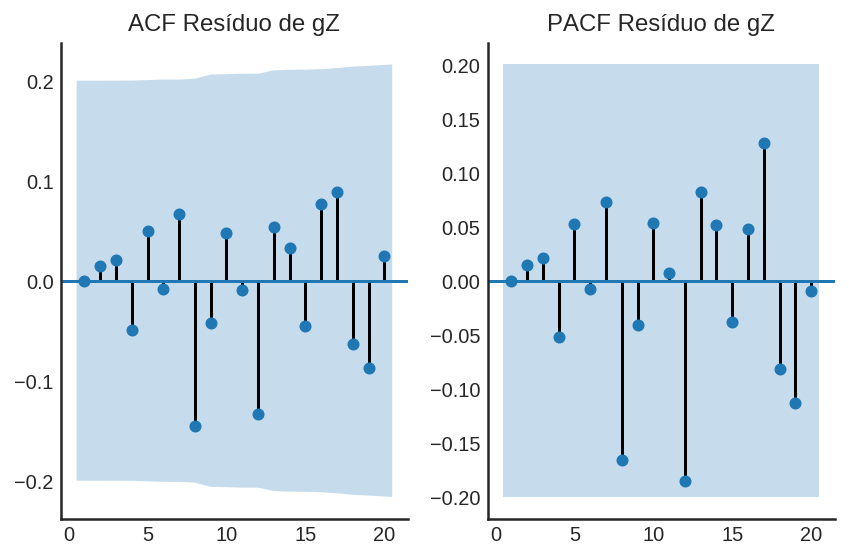

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         25.94          38.89   0.466 26
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         29.02          38.89   0.310 26
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  TAXA PRÓPRIA . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?

In [16]:
model = VECM(
    endog = df[[
        #"Inflação", 
        "Taxa Própria", 
        "gZ"
    ]], 
    #exog=df[["Taxa de juros"]],
    k_ar_diff=8,
    deterministic=det, 
)
results = model.fit()

with open('./tabs/VECM_ajuste.tex','w') as fh:
    fh.write(results.summary().as_latex())

print(results.summary())
print(60*"=")
print("\nPÓS ESTIMAÇÂO\n")
residuals = analise_residuos(results=results)
print(60*"=")

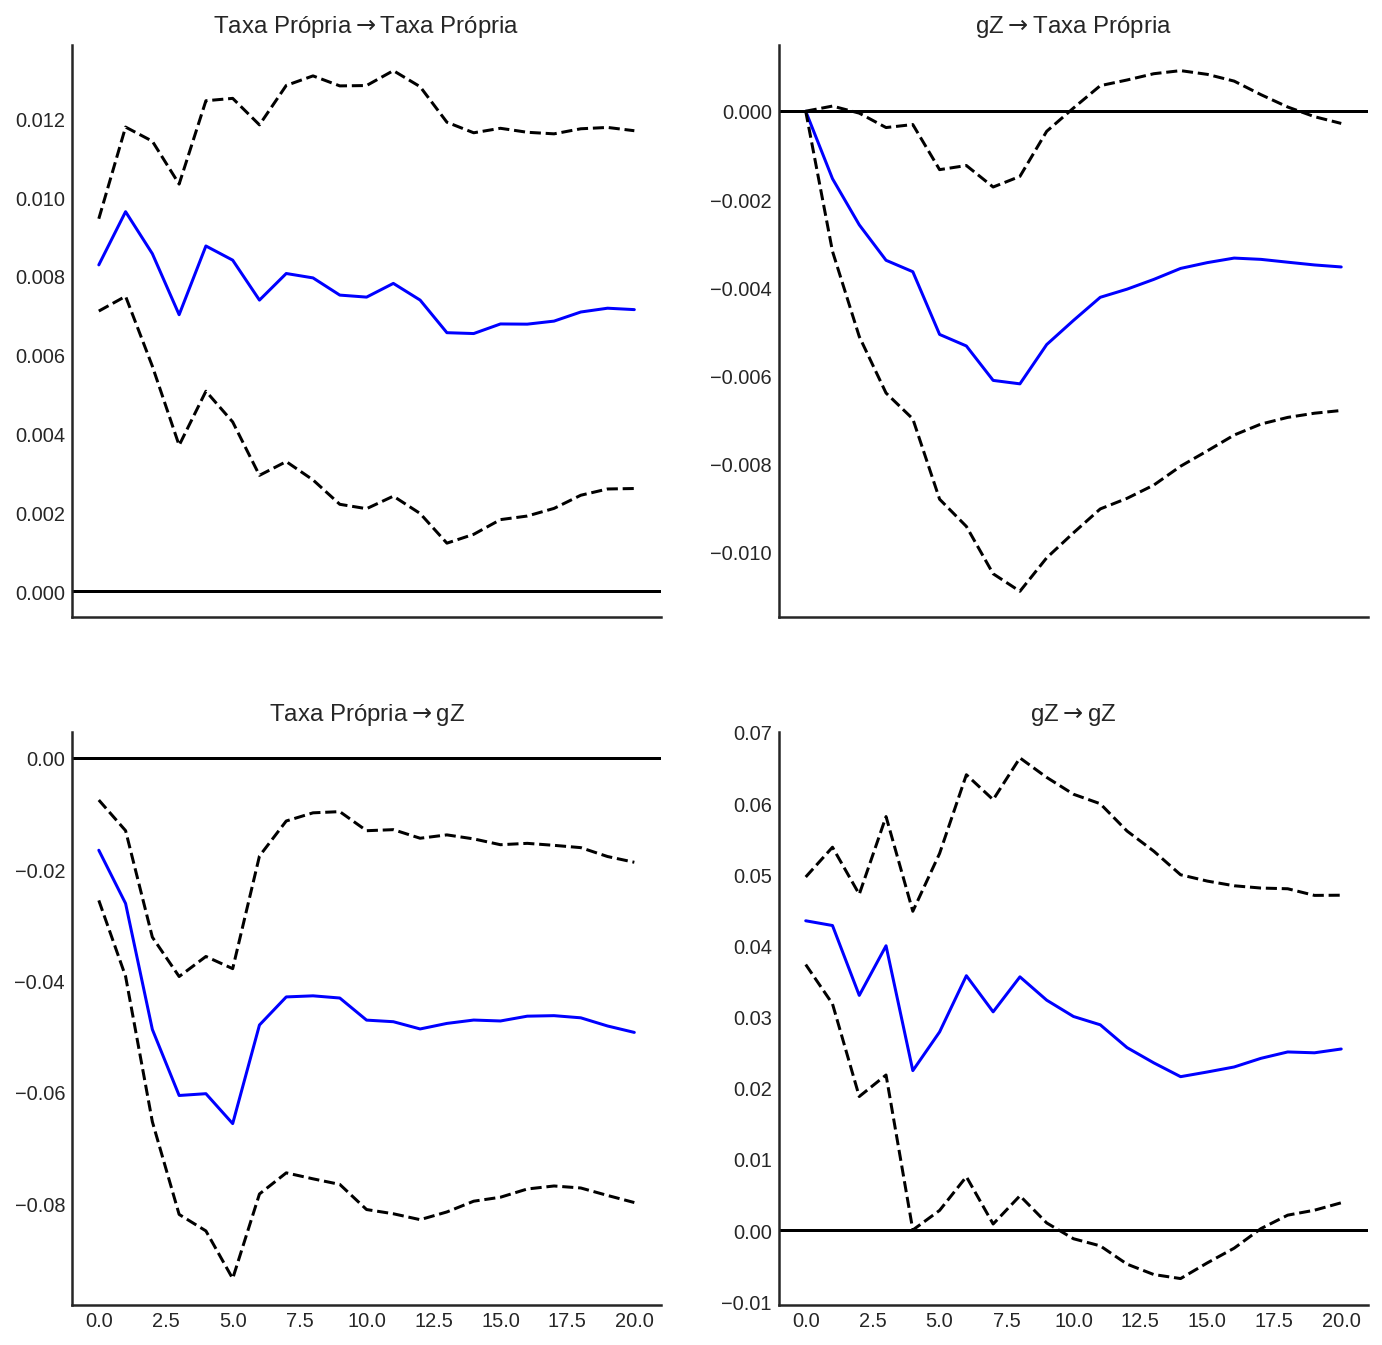

In [17]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECMOrth.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

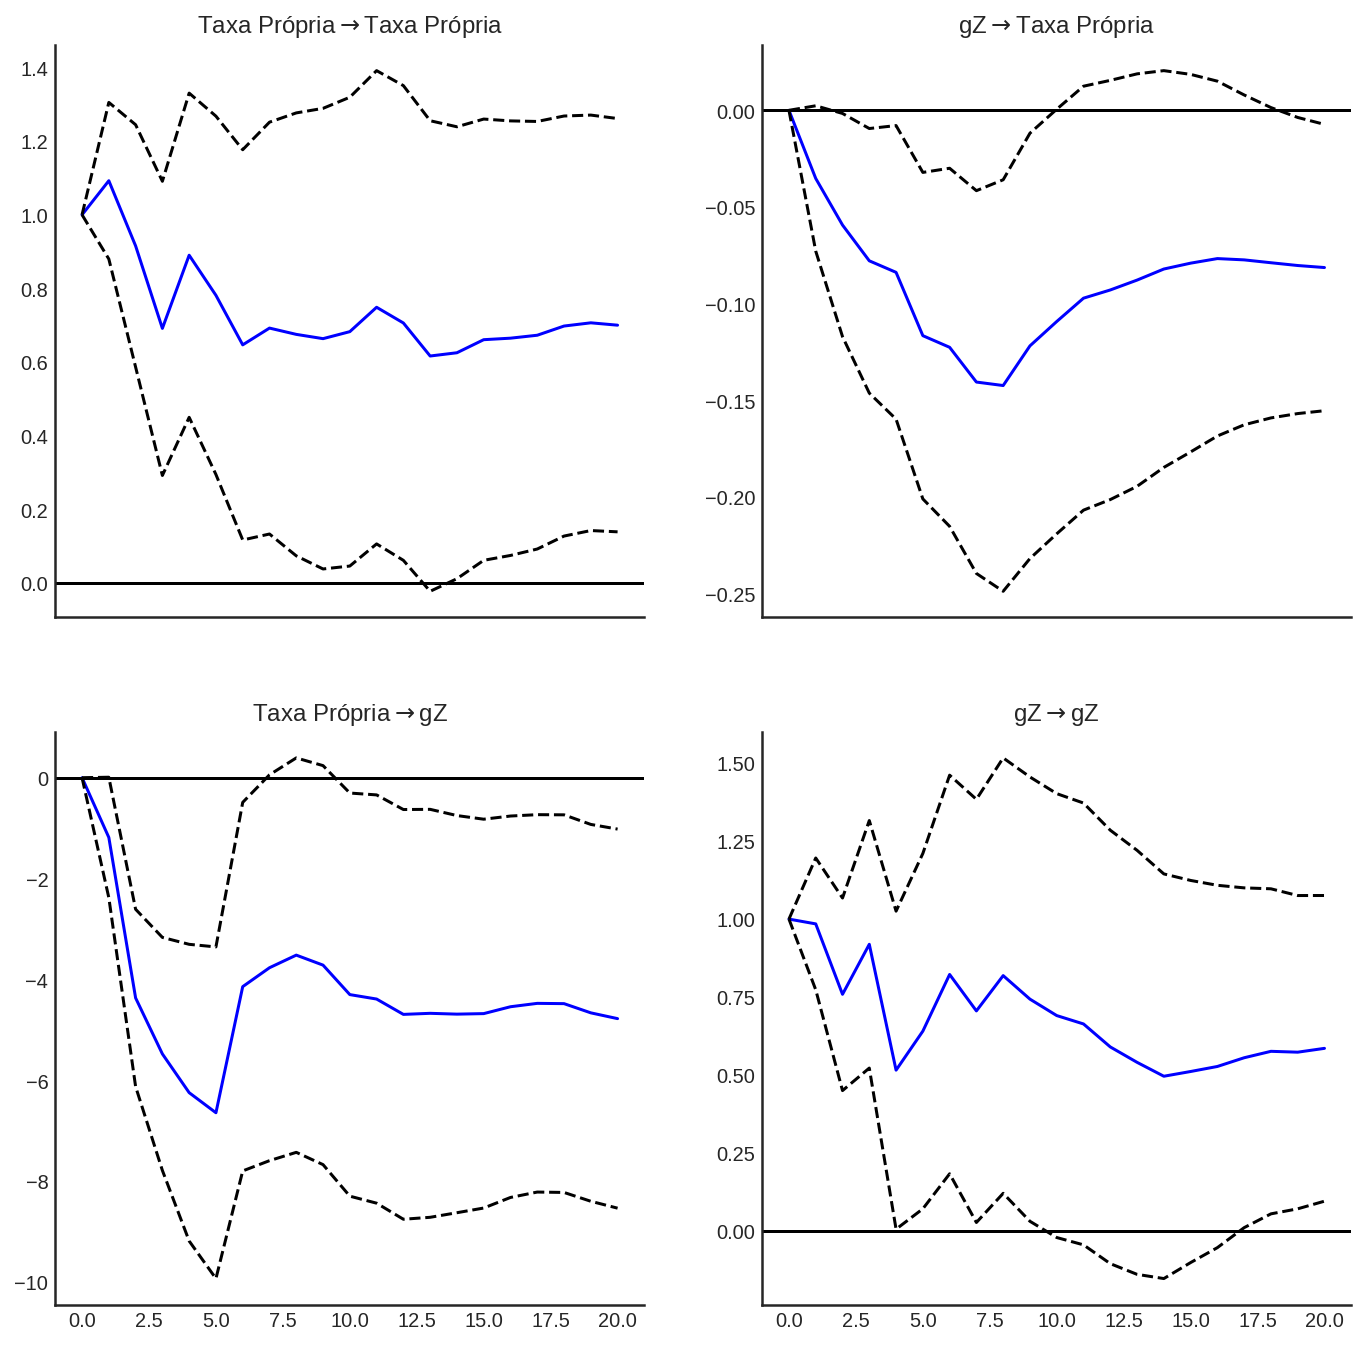

In [18]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

In [19]:
series = residuals.columns
print(results.test_granger_causality(causing=series[0], caused=series[1]).summary())
print(results.test_inst_causality(causing=series[0]).summary())

Granger causality F-test. H_0: Taxa Própria does not Granger-cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         3.909          1.945   0.000 (9, 146)
----------------------------------------------
Instantaneous causality Wald-test. H_0: Taxa Própria does not instantaneously cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         8.704          3.841   0.003  1
----------------------------------------


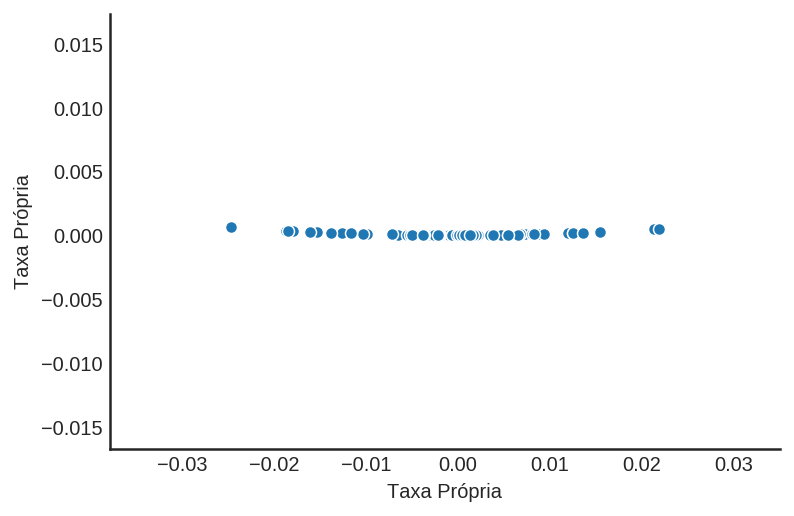

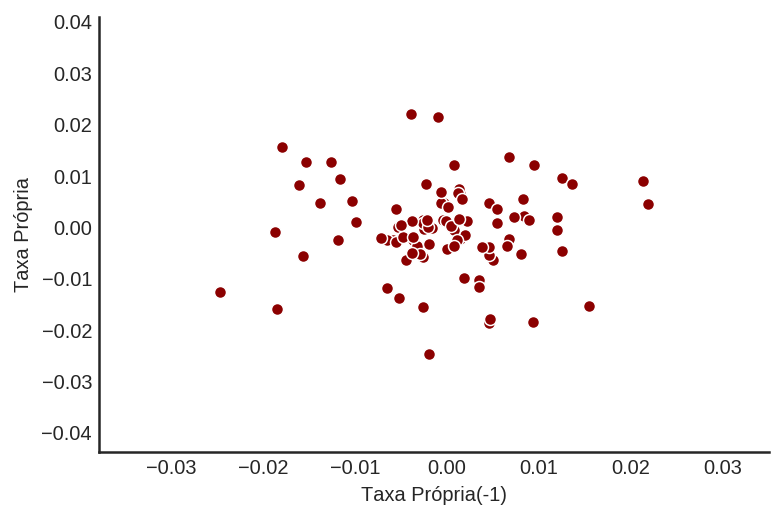

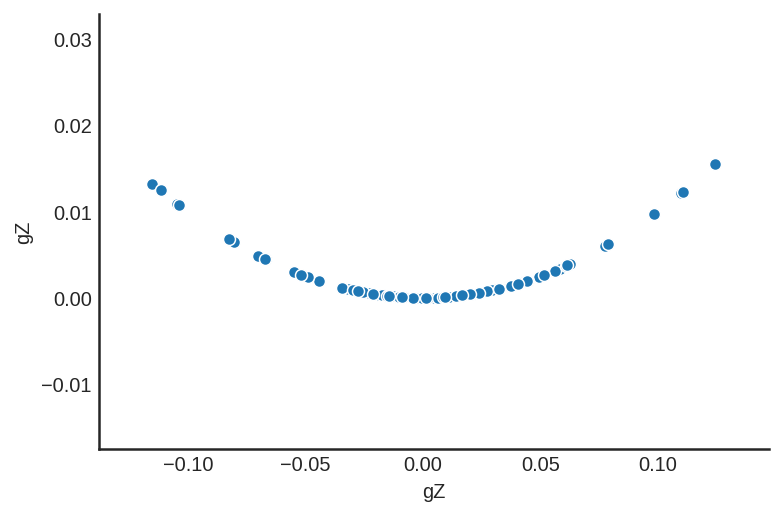

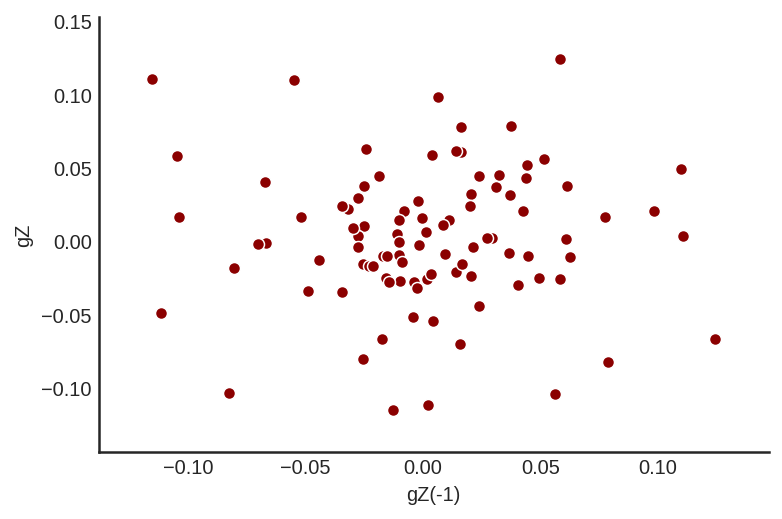

In [20]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

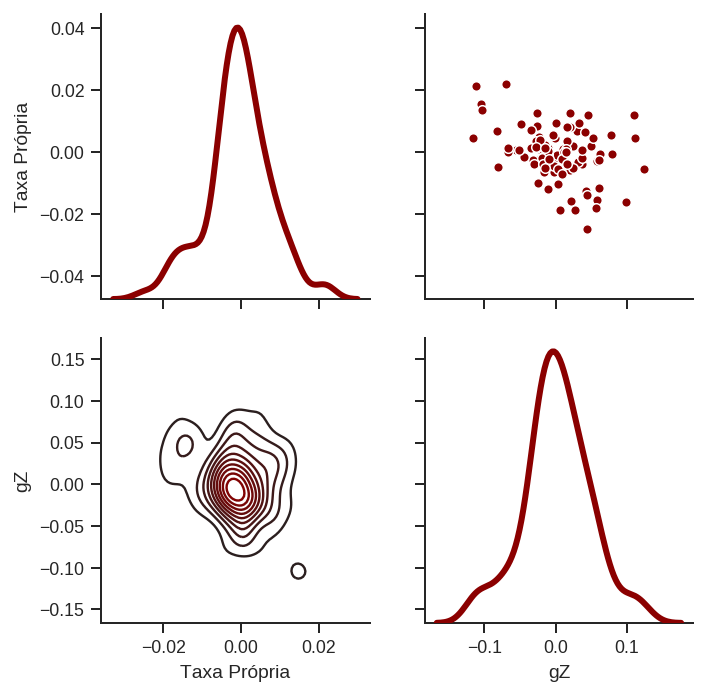

In [21]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

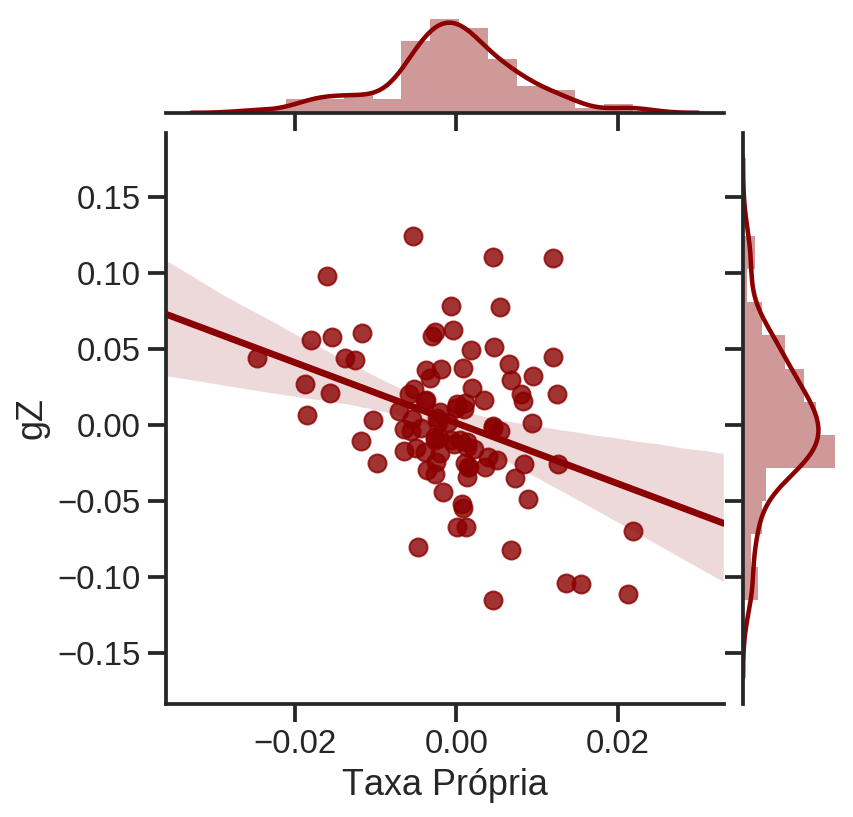

In [22]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

## FEVD

corrigir!!

In [23]:
%%R
library(strucchange)
library(urca)

R[write to console]: Carregando pacotes exigidos: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Carregando pacotes exigidos: sandwich



In [24]:
%%R -o fevd_gz
library(tsDyn)
library(readr)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
df <- df[,c(4:7)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- na.omit(df[,c("Juros", "Infla","TaxaP", "gZ")])
df <- ts(data = df, start = c(1993,03), frequency = 4)
model <- tsDyn::VECM(data = df[,c("TaxaP","gZ")], lag = 6, r = 1, estim = "ML", LRinclude="both", include="trend")
fevd_gz = data.frame(tsDyn::fevd(model, 20)$gZ)

R[write to console]: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff



In [25]:
%%R -o fevd_tx
fevd_tx = data.frame(tsDyn::fevd(model, 20)$TaxaP)

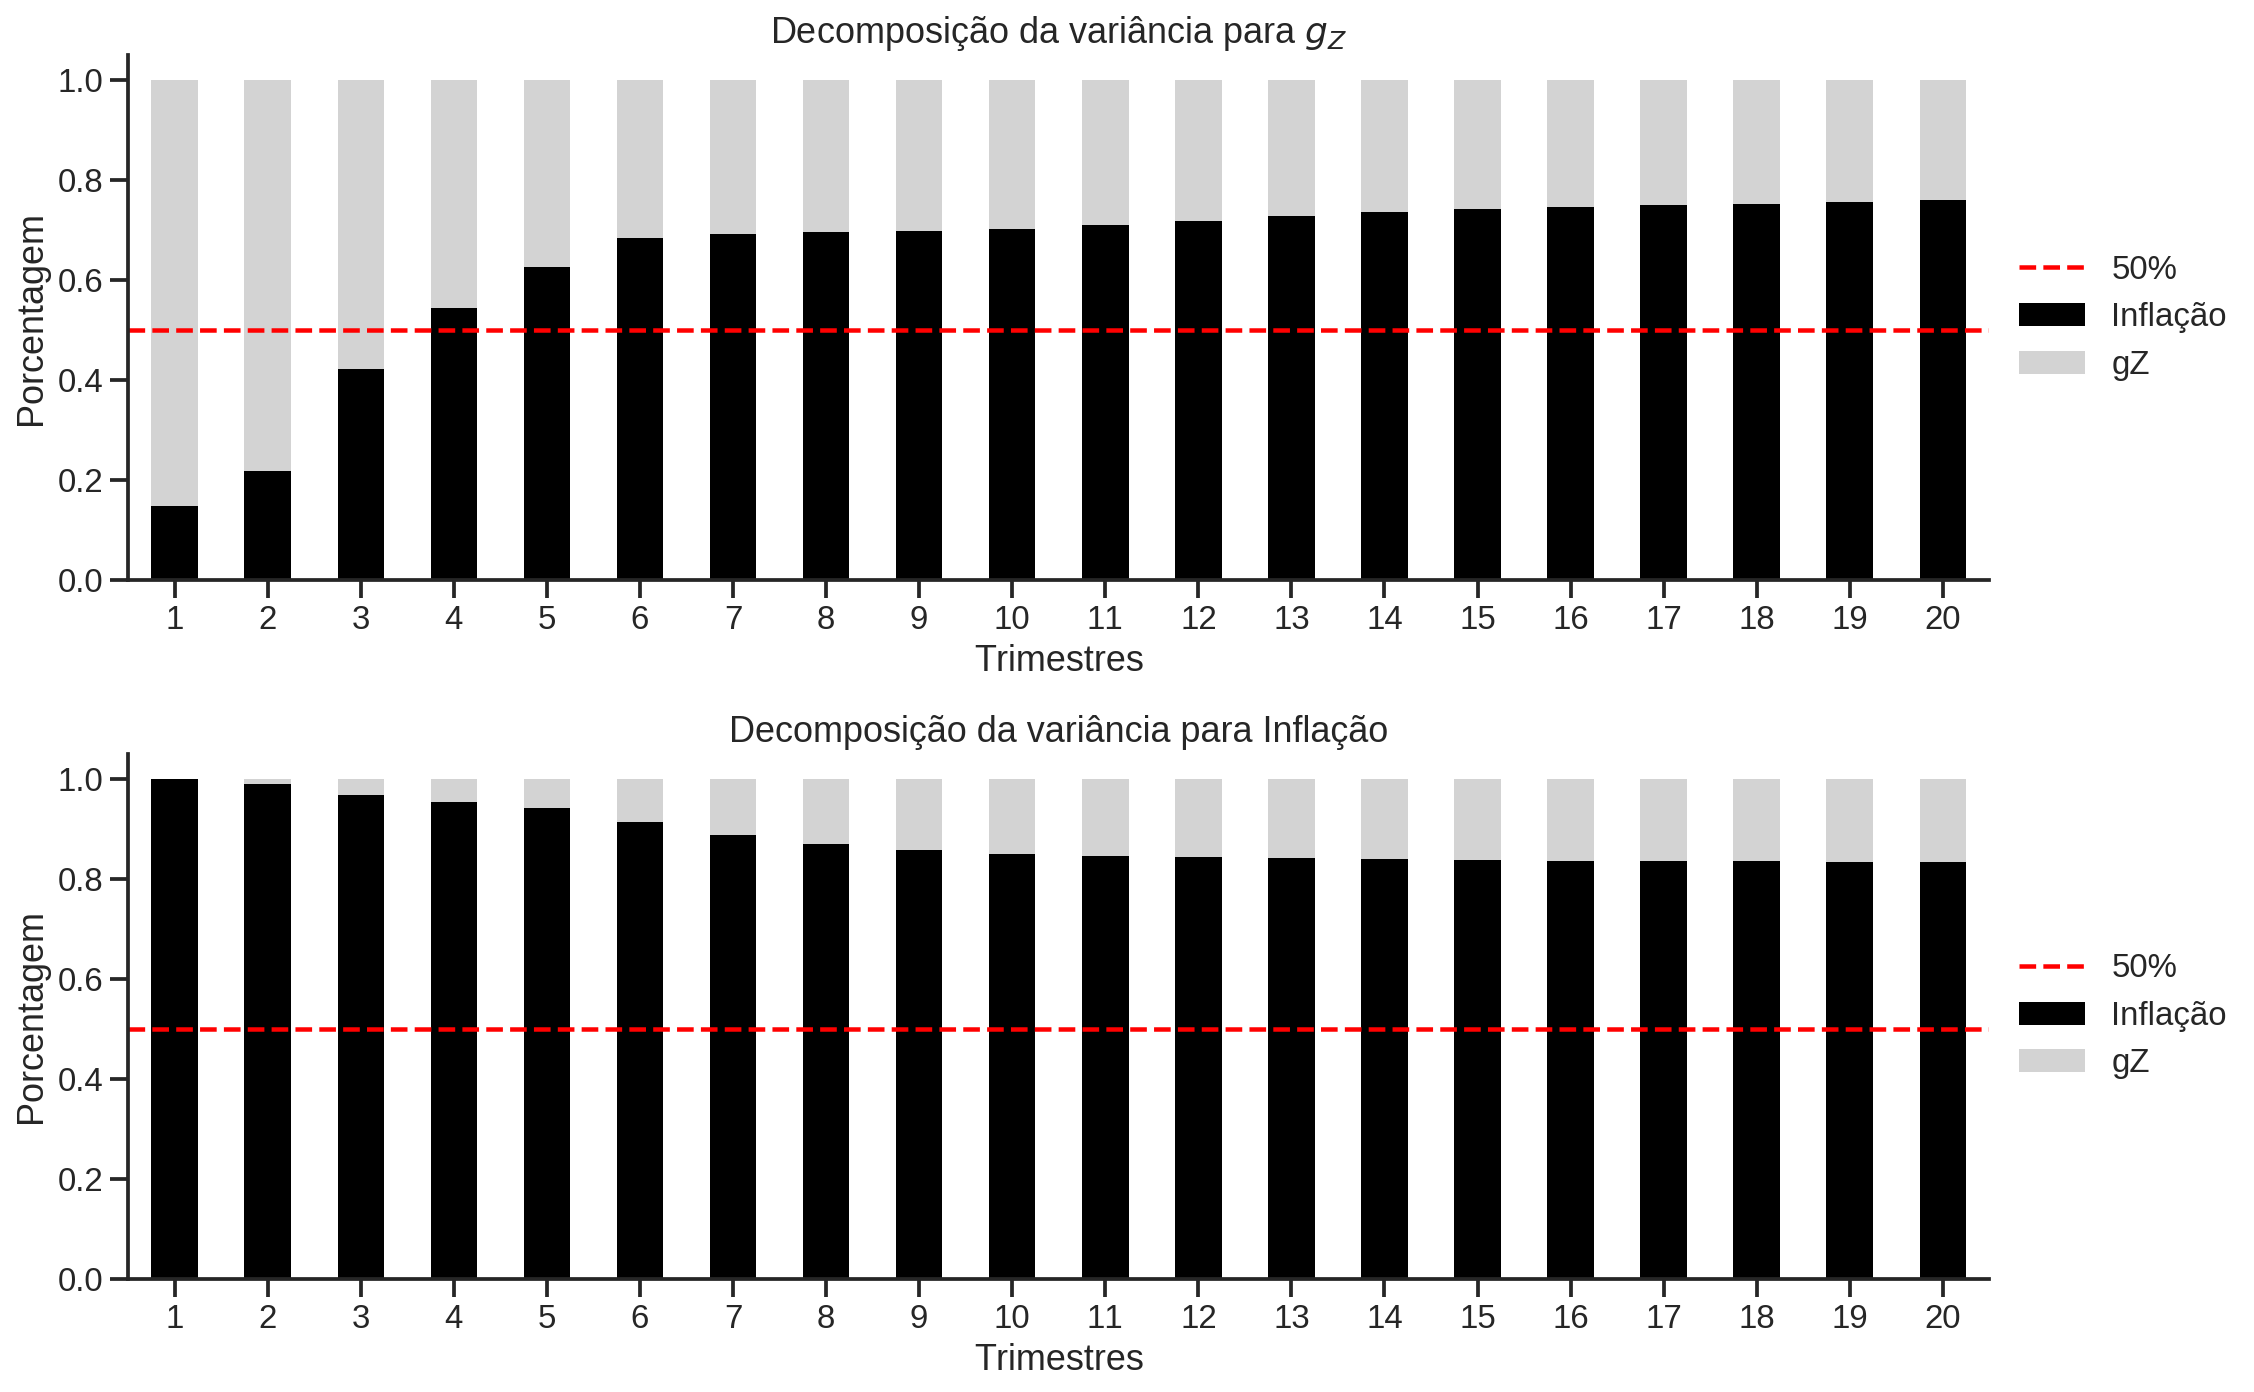

In [26]:
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize = (16,10))

fevd_gz.plot(
    ax=ax[0], 
    title = "Decomposição da variância para $g_Z$", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True
)
ax[0].set_xlabel('Trimestres')
ax[0].set_ylabel('Porcentagem')
ax[0].axhline(y=0.5, color = 'red', ls = '--')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)


fevd_tx.plot(
    ax=ax[1], 
    title = "Decomposição da variância para Inflação", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True,
)
ax[1].axhline(y=0.5, color = 'red', ls = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[1].set_xlabel('Trimestres')
ax[1].set_ylabel('Porcentagem')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("./figs/FEVD_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# VAR

**Dúvida:** Variável exógena do VAR deve ser estacionária também?

In [27]:
model = VAR(
    df[["d_Taxa Própria", 'd_gZ']],
)
print(model.select_order(maxlags=15, trend='ct').summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -14.89     -14.78*   3.416e-07     -14.84*
1       -14.85      -14.62   3.566e-07      -14.76
2       -14.88      -14.55   3.442e-07      -14.75
3       -14.85      -14.40   3.562e-07      -14.67
4       -15.04      -14.49   2.940e-07      -14.82
5      -15.08*      -14.42  2.824e-07*      -14.81
6       -15.08      -14.30   2.848e-07      -14.76
7       -15.01      -14.12   3.061e-07      -14.65
8       -15.06      -14.06   2.902e-07      -14.66
9       -14.99      -13.87   3.149e-07      -14.54
10      -14.93      -13.70   3.363e-07      -14.43
11      -14.91      -13.57   3.452e-07      -14.37
12      -14.86      -13.41   3.654e-07      -14.27
13      -14.90      -13.35   3.516e-07      -14.28
14      -14.83      -13.17   3.813e-07      -14.16
15      -14.83      -13.05   3.882e-07      -14.11
-------------------------------

Adotando o BIC como critério de seleção dada a parciomônia, estima-se uma VAR de ordem 5.

## Estimação

In [28]:
results = model.fit(maxlags=5)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           qui, 28, nov, 2019
Time:                     09:26:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.5102
Nobs:                     100.000    HQIC:                  -14.8514
Log likelihood:           492.379    FPE:                2.81949e-07
AIC:                     -15.0833    Det(Omega_mle):     2.28836e-07
--------------------------------------------------------------------
Results for equation d_Taxa Própria
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.000879         0.000955           -0.921           0.357
L1.d_Taxa Própria         0.175223         0.105452            1.662           0.097
L1.d_gZ                  -0.018505 

## Inspeção

### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

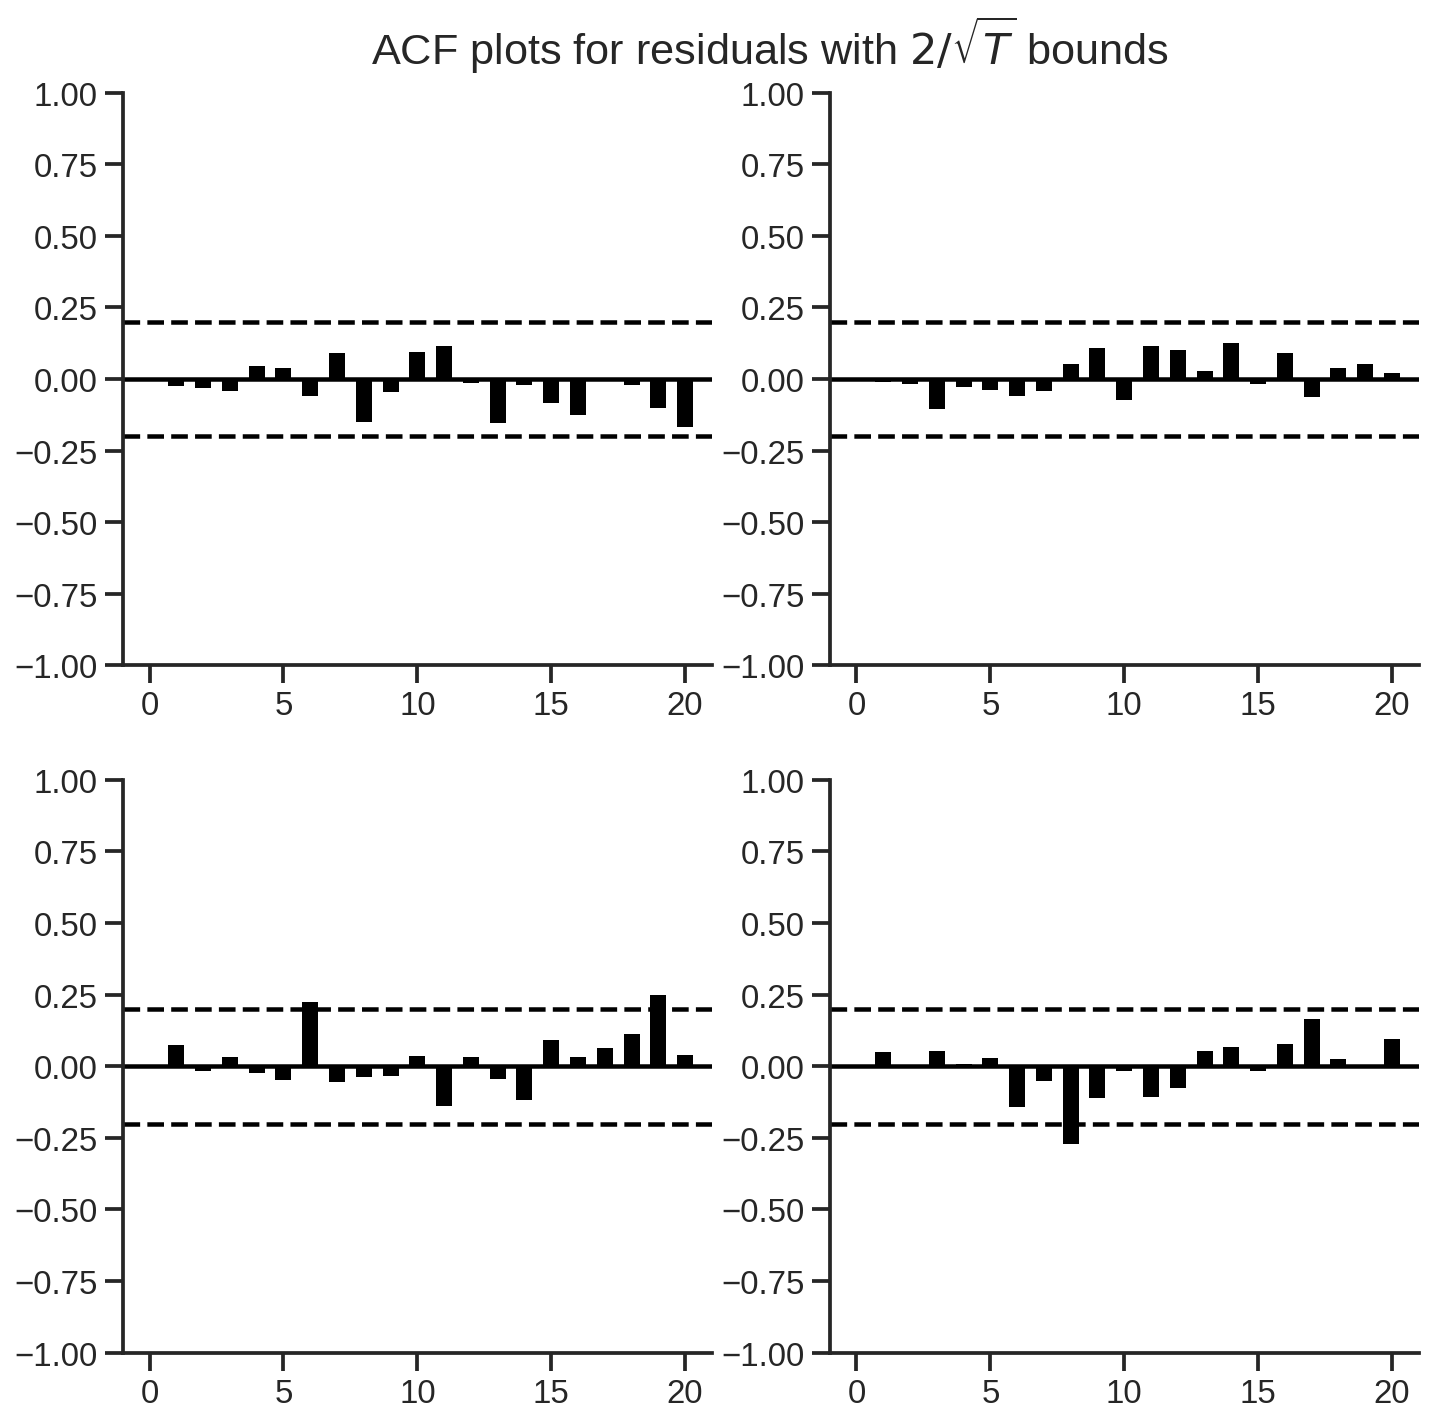

In [29]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

**Conclusão:** Pela inspeção gráfica, o modelo não apresenta autocorrelação seria dos resíduos.

### Estabilidade

In [30]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.7814095708514468
0.8436193177767725
0.8436193177767725
0.7561476511076933
0.7561476511076933
0.8504123503231067
0.8504123503231067
0.5617318375392895
0.5228751364388415
0.5228751364388415
Estável: True


**OBS:** Apesar de estar escrito VAR(1), os resultados acima correspondem ao VAR(p)

## Inspeção dos resíduos

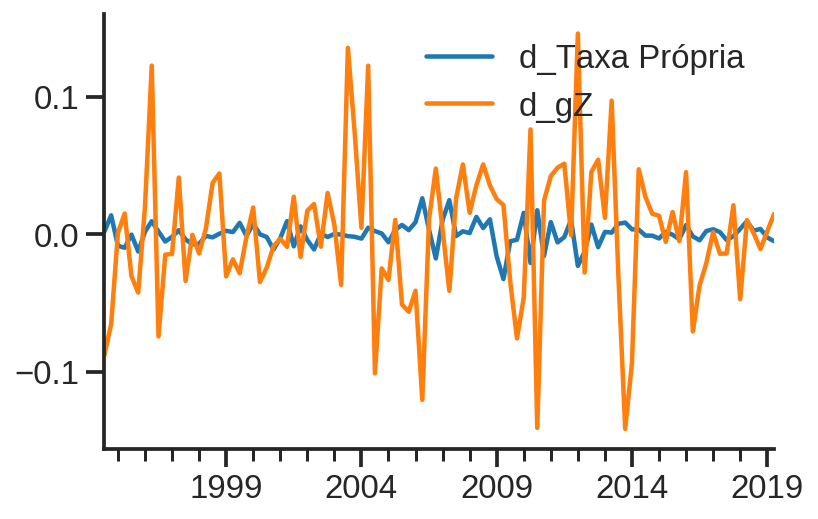

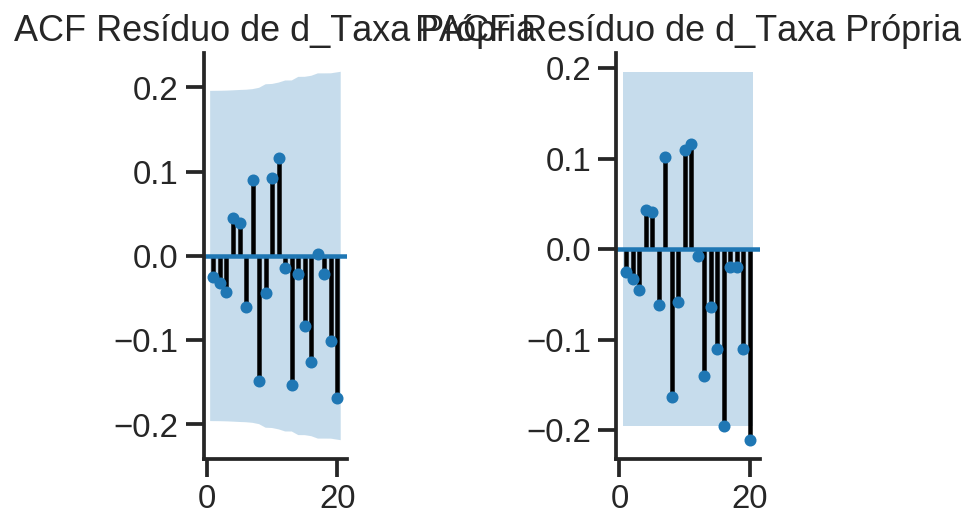

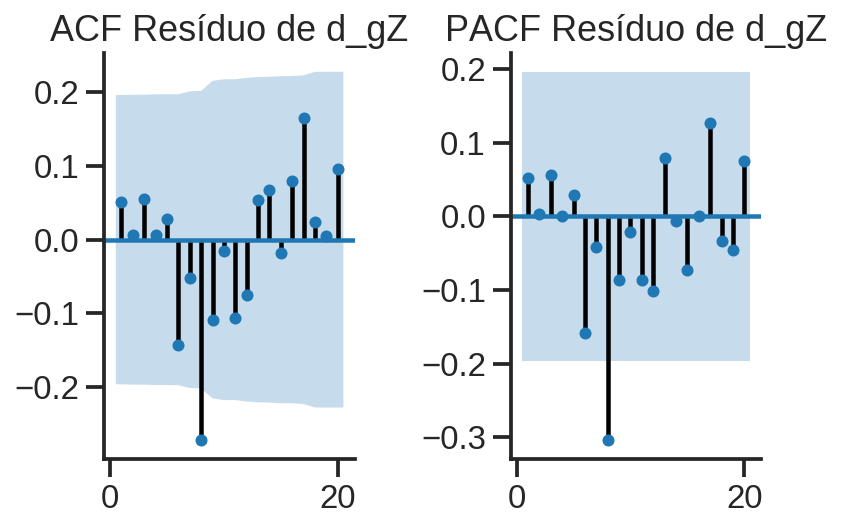

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         46.14          55.76   0.233 40
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         50.74          55.76   0.119 40
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  D_TAXA PRÓPRIA . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3

In [31]:
residuals = analise_residuos(results=results)

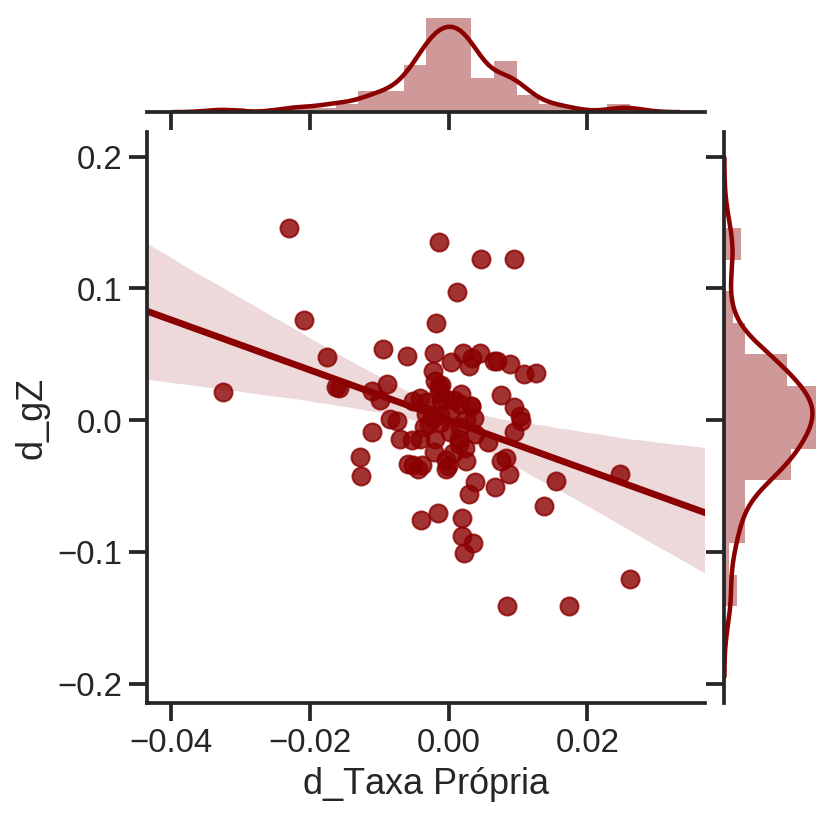

In [32]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

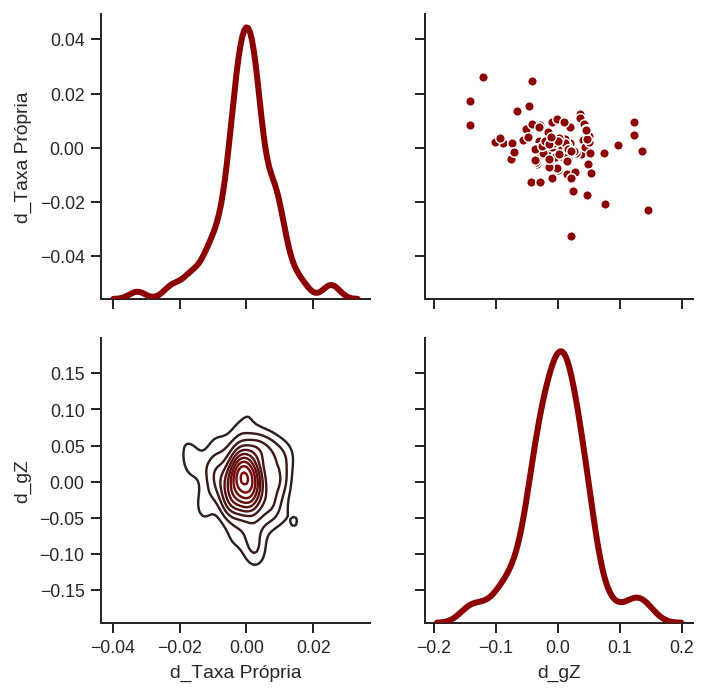

In [33]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4.png", dpi=300)

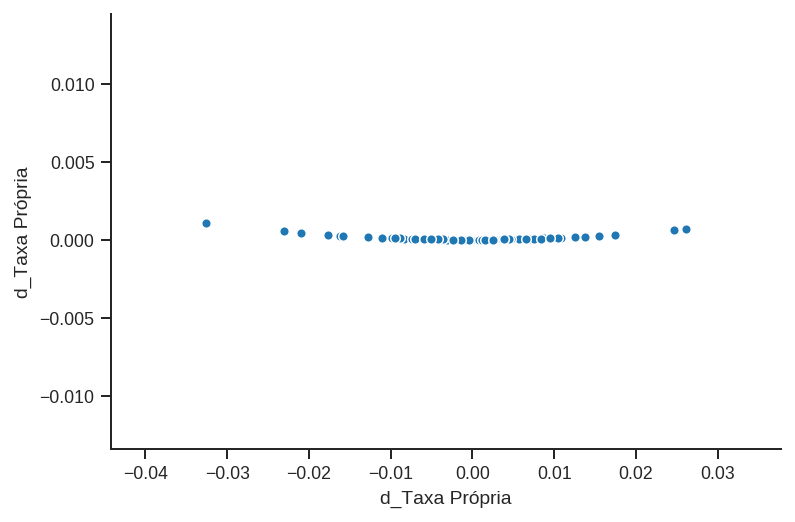

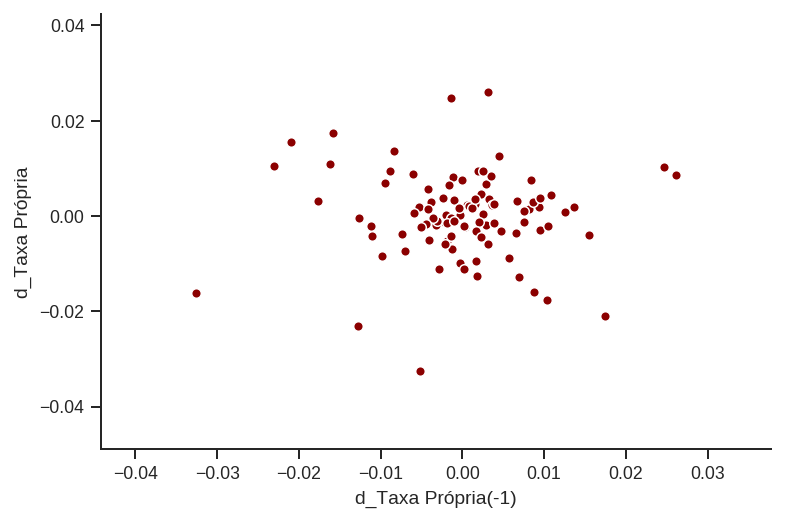

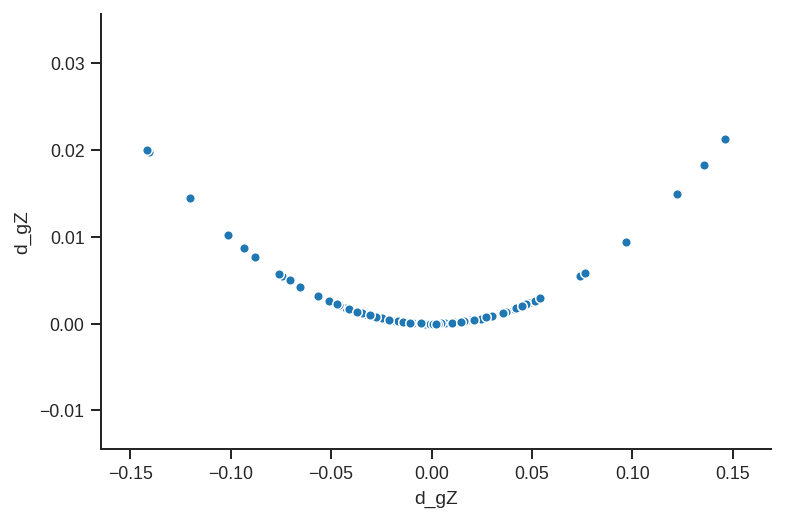

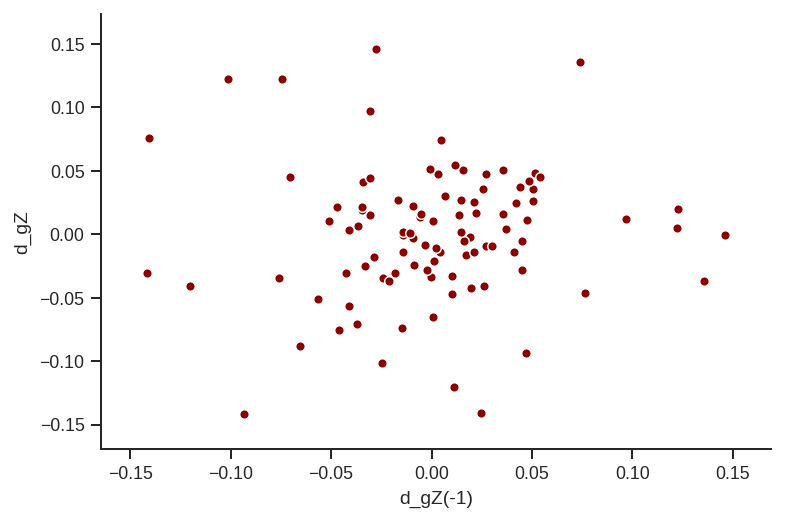

In [34]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

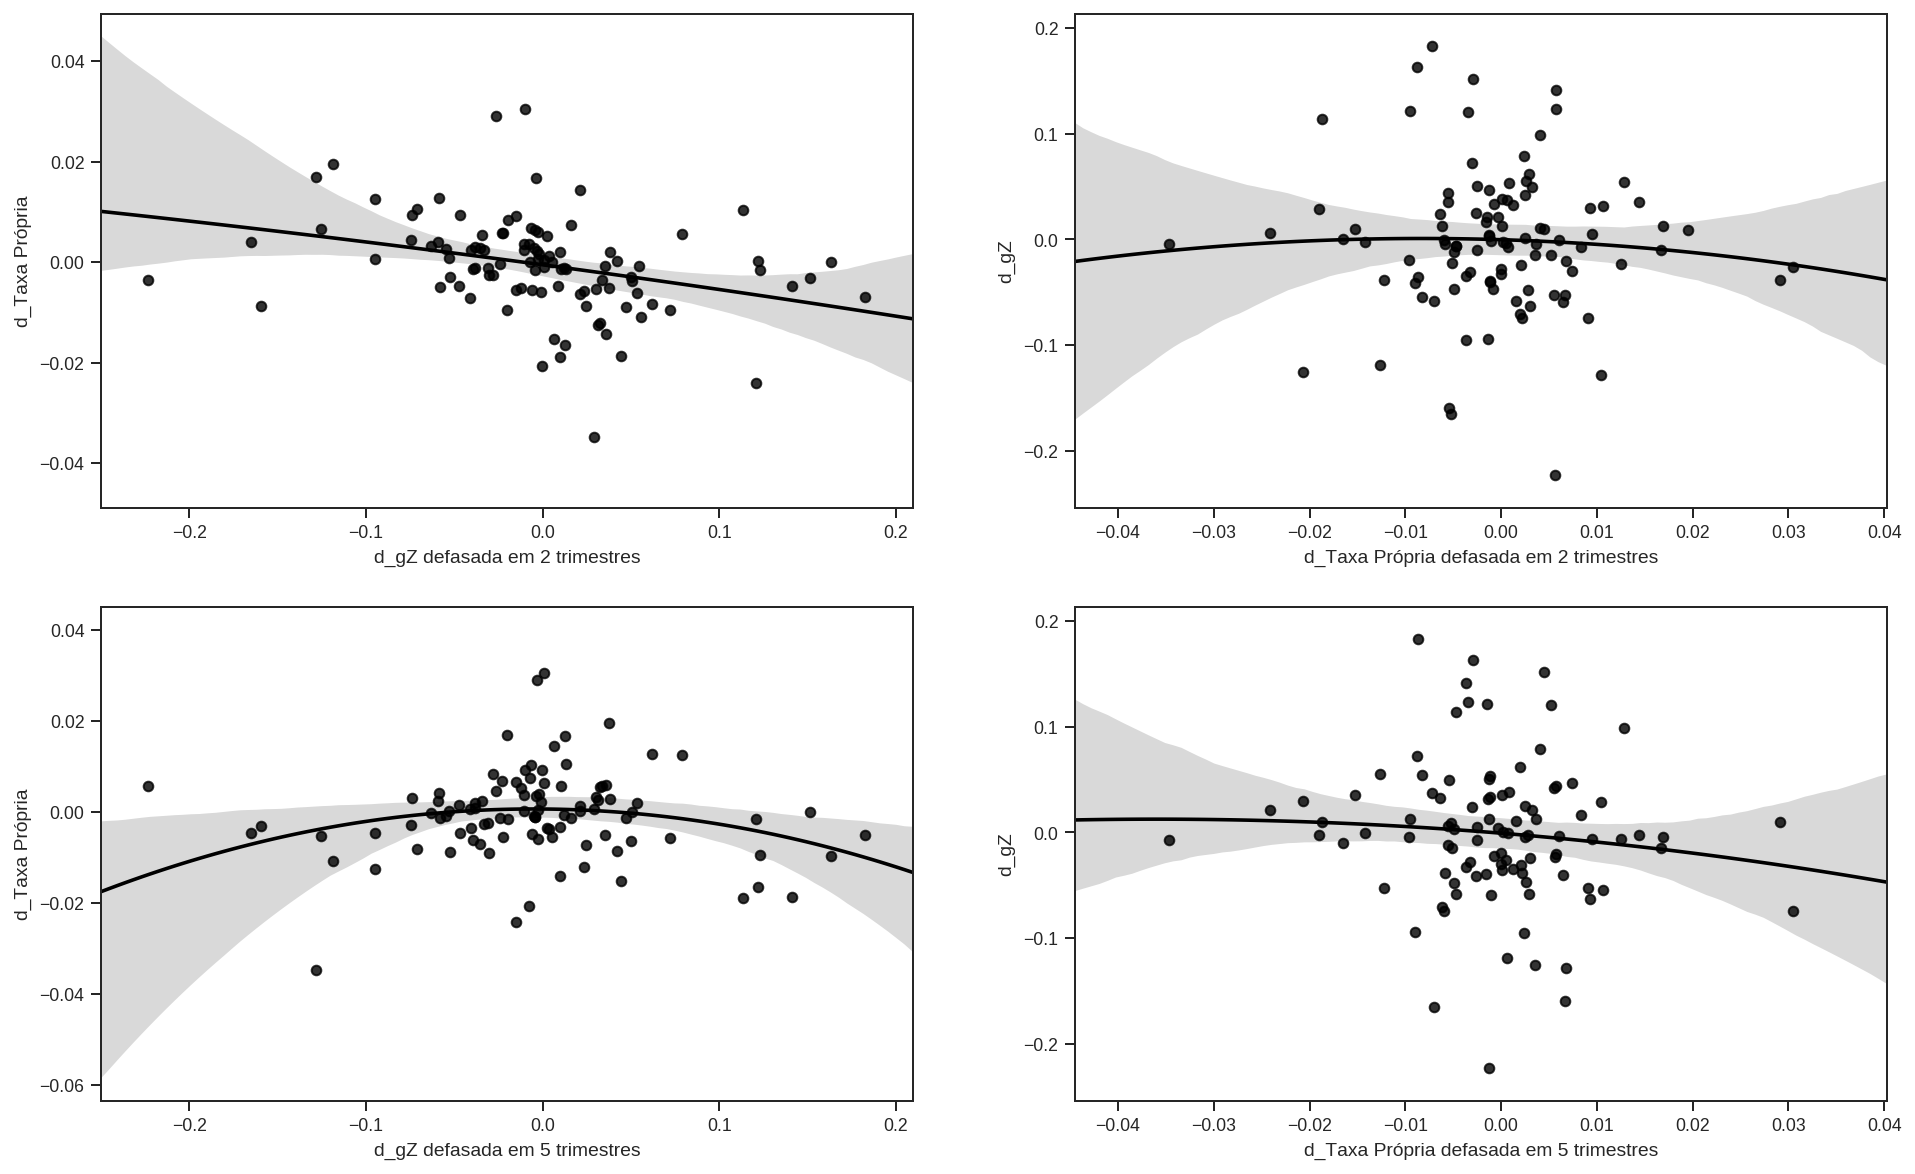

In [35]:
plot_lags(results=results)

## Função resposta ao impulso

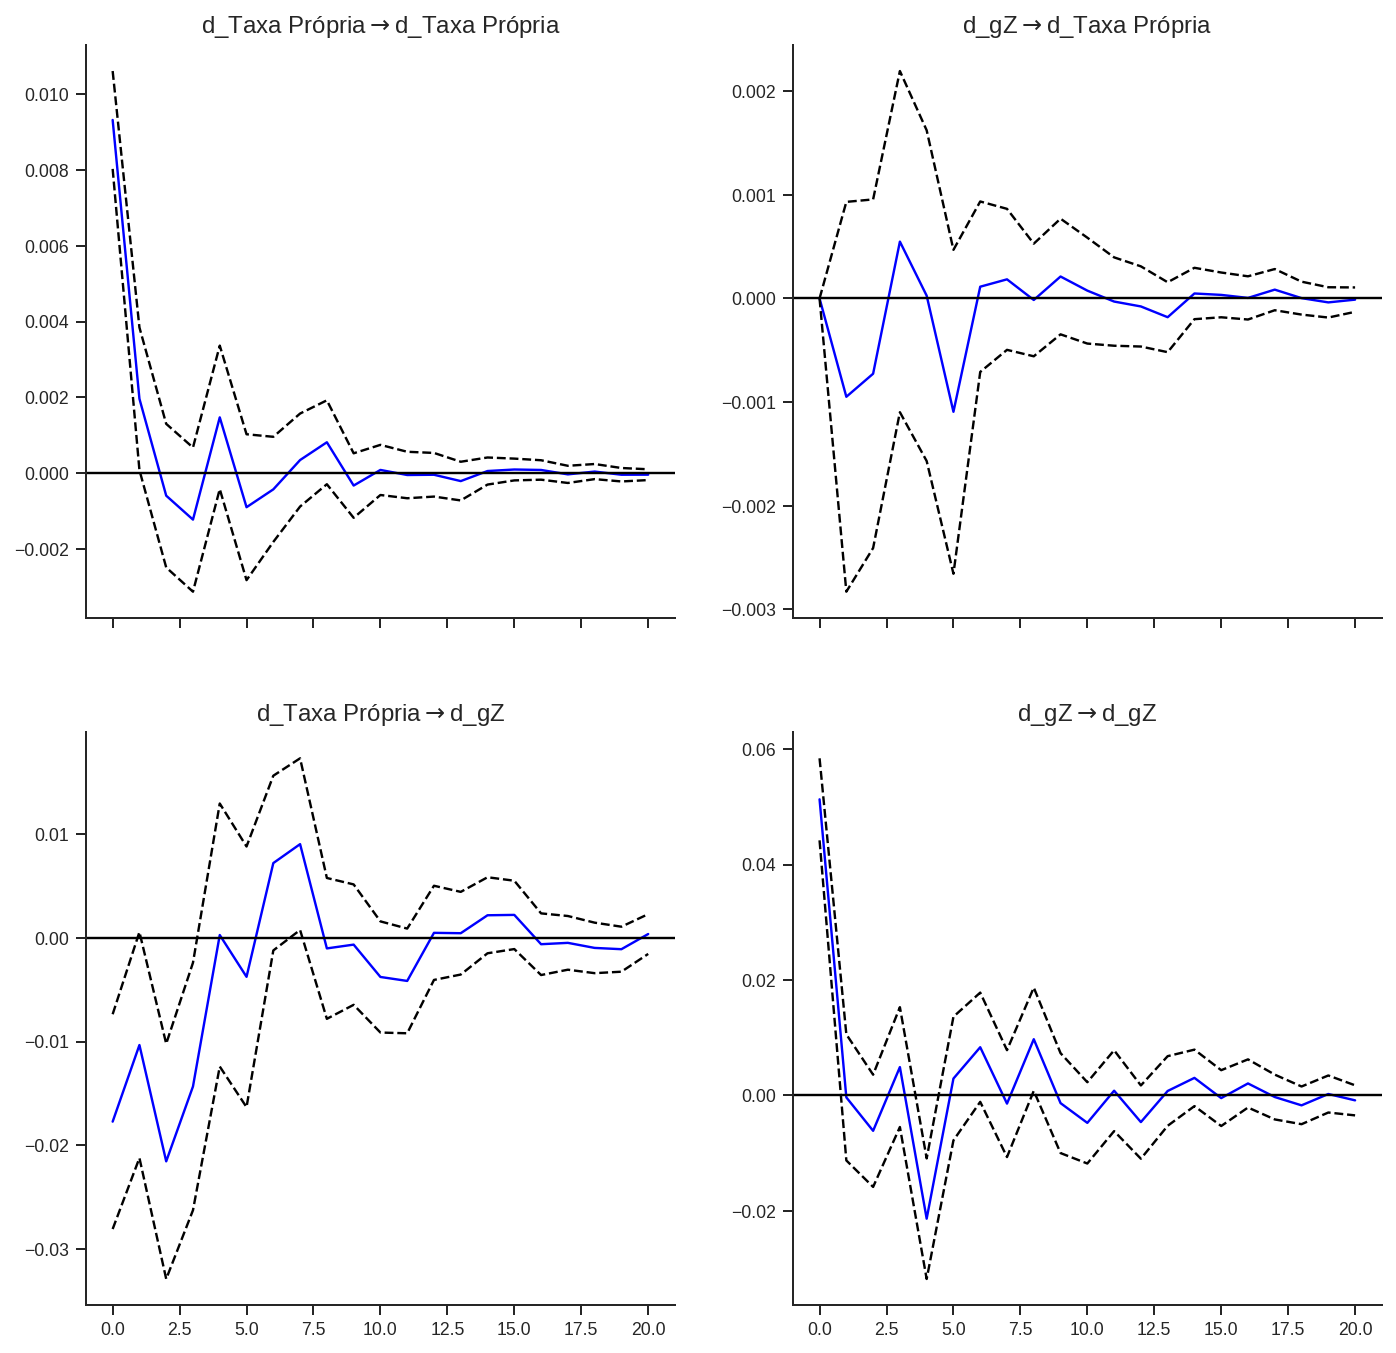

In [36]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Orth.png", dpi = 300)

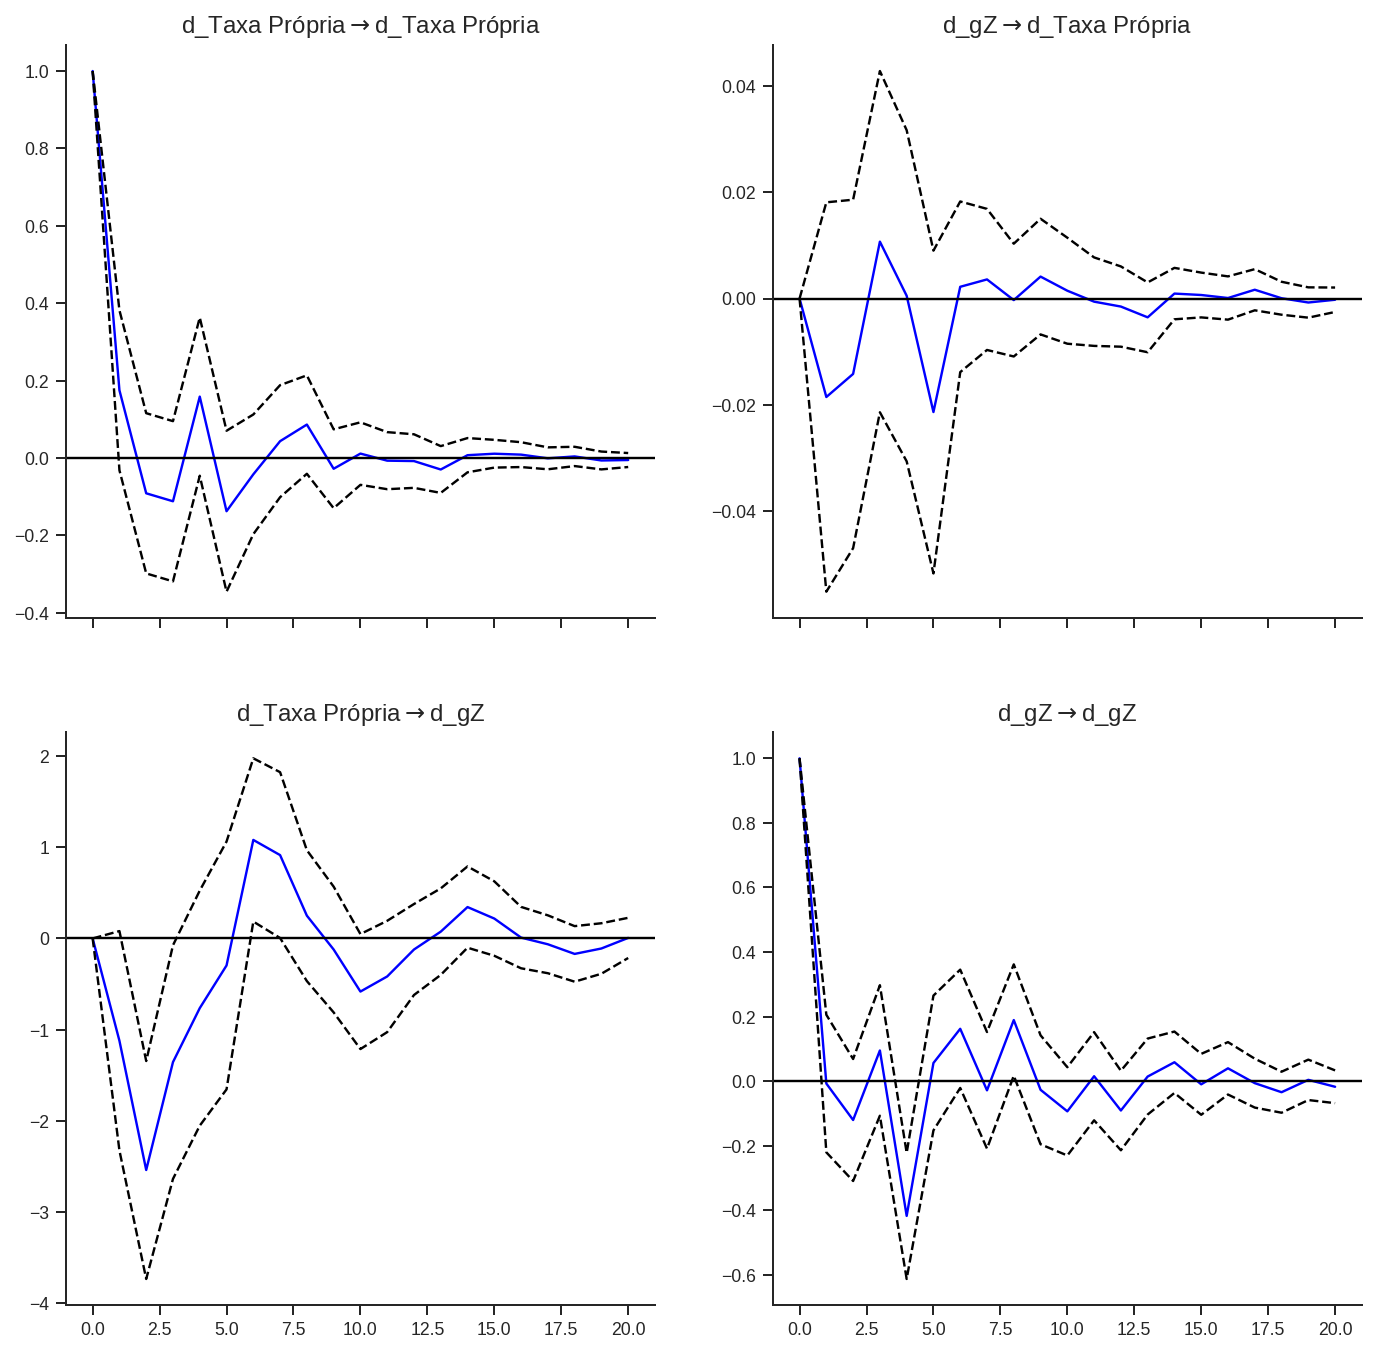

In [37]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso.png", dpi = 300)

## Efeito cumulativo

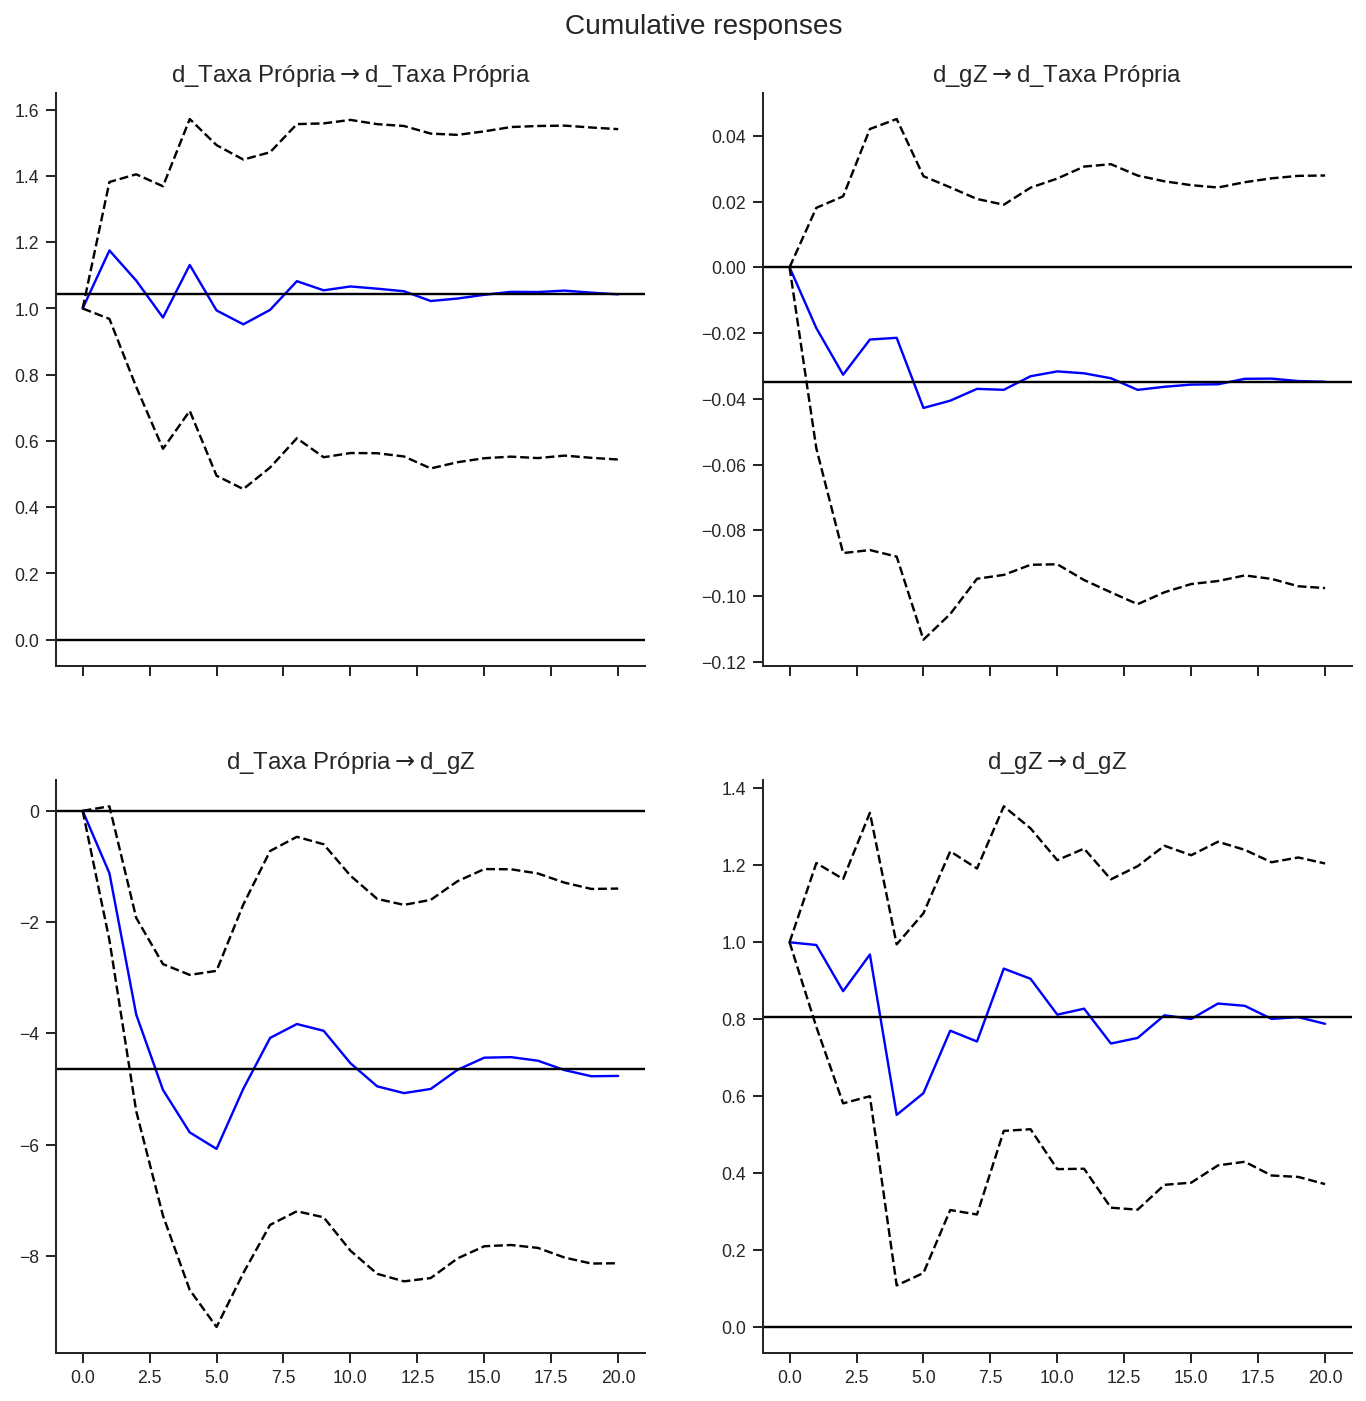

In [38]:
p = results.irf(20).plot_cum_effects(orth=False)
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Cum.png", dpi = 300)

## Decomposição da variância

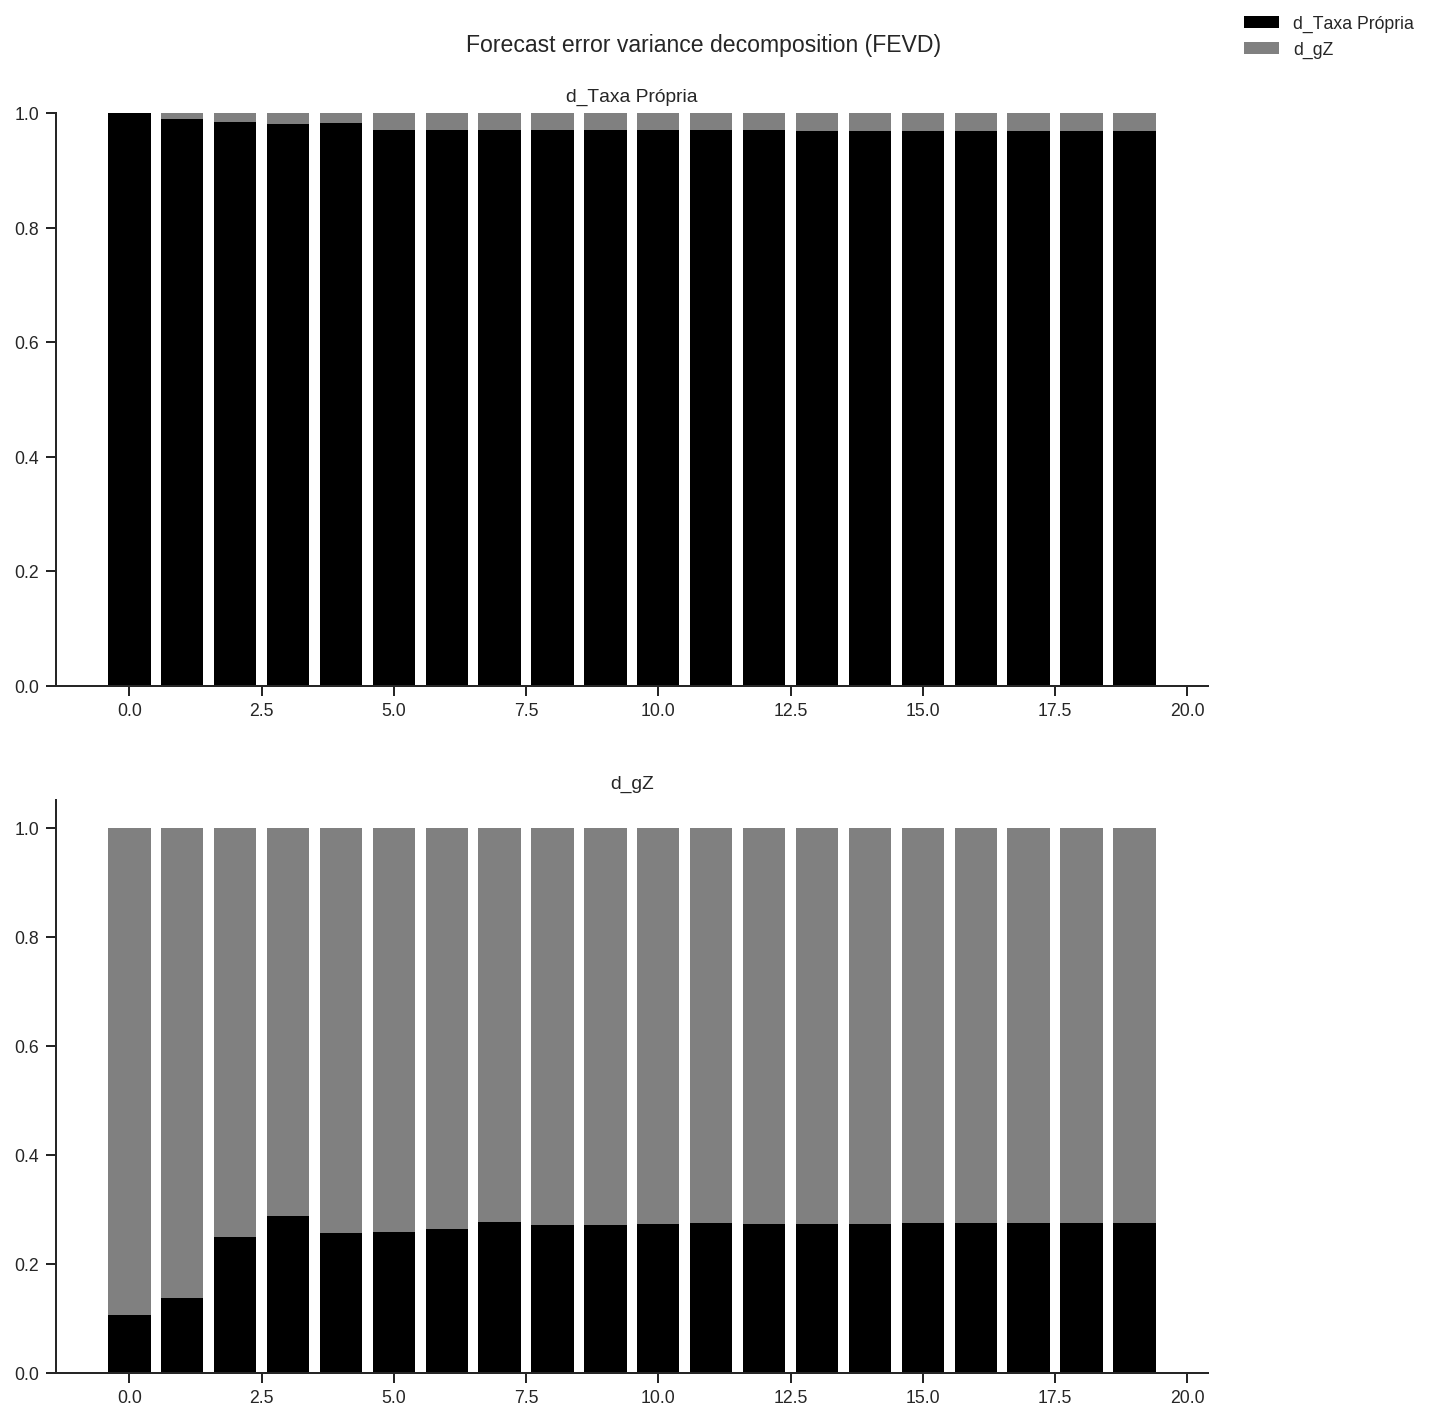

In [39]:
p = results.fevd(20).plot()
sns.despine()
plt.show()
p.savefig("./figs/DecompVar.png", dpi = 300)